# **Bike Rental Forecasting**

## Dataset Overview

The Capital Bikeshare dataset captures bike rental patterns in Washington D.C. over a two-year period (2011-2012). This comprehensive dataset consists of 17,389 hourly records with 13 features that track bicycle sharing system usage alongside corresponding weather and seasonal information.

The dataset includes temporal variables (date, hour, month, year, season), calendar-related features (holiday status, weekday, working day), and environmental conditions (weather situation, temperature, perceived temperature, humidity, and wind speed). The primary target variable is the total count of rental bikes, which is further broken down into casual and registered users.

[**Dataset Link**](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)

## **Data Inspection and Preperation**

In this section I will be observing everything about our dataset, its statistical features, time series components, distributions and visualize everything for better interpretation. Also I will transform it properly for the model benchmarking and other actions that we have ahead

Before we do all that, let's first make a little cell dedicated to the importation of all the requirements we will need throughout the project

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw
import warnings
import plotly.subplots as sp
import scipy.stats as stats
import logging
from statsmodels.graphics.tsaplots import plot_acf

In [8]:
df = pd.read_csv(r'C:\Users\user\Desktop\bike.csv')

In [9]:
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,1/1/2011,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,1/1/2011,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,1/1/2011,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,1/1/2011,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,1/1/2011,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


To say it briefly, we have lots of independent variables that influence our bike sharing count, which is our target variable. As we want to make univariate time series forecasting we have to maintain only 2 usable columns: Datetime and Count. Since we have lots of date-related columns, such as year, month, season, hour and etc, we have to make some transformations to create 1 datetime column, and get rid of the other ones. About the non-date-related columns, we only need cnt column.

In [12]:
df['dteday'] = pd.to_datetime(df['dteday'])

df['datetime'] = pd.to_datetime(df['dteday'].astype(str) + ' ' + df['hr'].astype(str) + ':00:00')

df.set_index('datetime', inplace=True)

df.sort_index(inplace=True)

In [13]:
df = df[['cnt']]

In [14]:
print(df.head())

                     cnt
datetime                
2011-01-01 00:00:00   16
2011-01-01 01:00:00   40
2011-01-01 02:00:00   32
2011-01-01 03:00:00   13
2011-01-01 04:00:00    1


And here we have fully ready dataframe, which has a datetime column as an index and cnt columns as our dependent variable. Now we can examine our time series data and its components, but before we do that let's quickly check if we have any duplicate values or other issues in our ts data

In [16]:
duplicates = df.index.duplicated()
print(f"\nDuplicate timestamps: {sum(duplicates)}")
if sum(duplicates) > 0:
    print("First few duplicate timestamps:")
    print(df[duplicates].head())


Duplicate timestamps: 0


In [17]:
negative_counts = df[df['cnt'] < 0]
print(f"\nNegative counts: {len(negative_counts)}")


Negative counts: 0


In [18]:
print("\nBasic statistics:")
print(df['cnt'].describe())


Basic statistics:
count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64


Okay so we got no duplicates in out datetime and no negative or missing values in our cnt variable, which is a good sign. Now let's check if some of the timestamps are missing from our datetime, because time series always needs to be continuous for quality forecasting

In [20]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing = full_range.difference(df.index)
print(missing)

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               ...
               '2012-10-30 07:00:00', '2012-10-30 08:00:00',
               '2012-10-30 09:00:00', '2012-10-30 10:00:00',
               '2012-10-30 11:00:00', '2012-10-30 12:00:00',
               '2012-11-08 03:00:00', '2012-11-29 03:00:00',
               '2012-12-24 04:00:00', '2012-12-25 03:00:00'],
              dtype='datetime64[ns]', length=165, freq=None)


Since some hours are missing in the data, backward fill seems to be the most appropriate method to handle those missing hours. The reason is that it is reasonable to assume that the bike rental count for a missing hour will be similar to the count from the next available hour. This makes sense because bike rental counts don't typically fluctuate drastically from one hour to the next.

In [22]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
df = df.reindex(full_range)

df['cnt'] = df['cnt'].bfill()

df['cnt'] = df['cnt'].astype(int)

df.index.name = 'datetime'

In [23]:
df.head()

,cnt
datetime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


In [24]:
missing = full_range.difference(df.index)
print(missing)

DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq='h')


All the issues fixed, let's visualize our time series

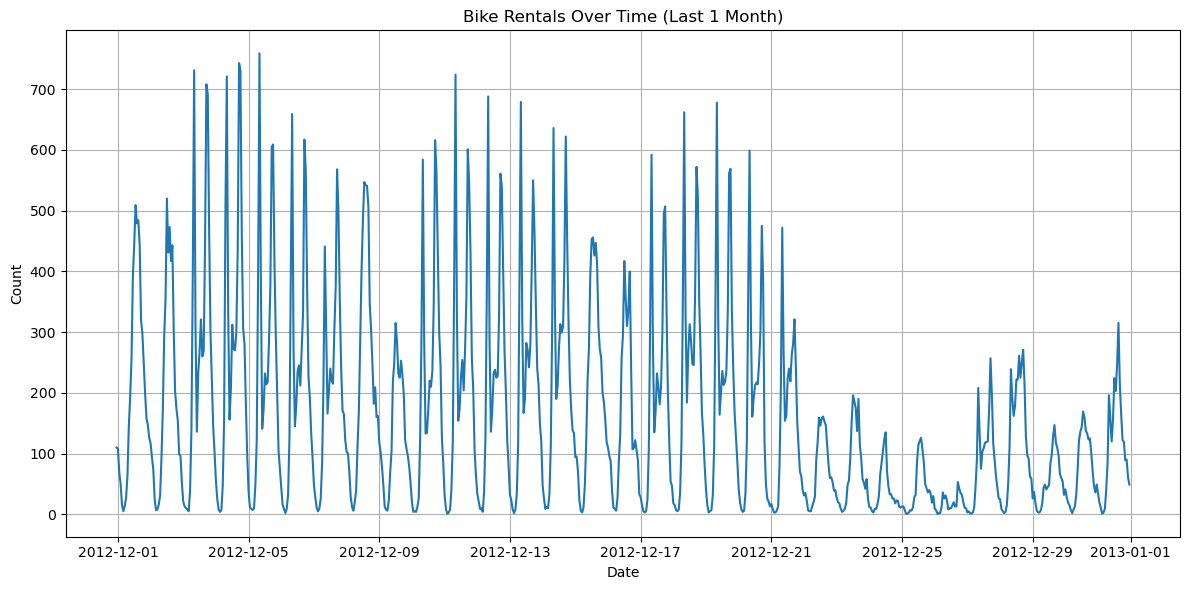

In [26]:
last_date = df.index.max()
one_month_ago = last_date - pd.DateOffset(months=1)
df_last_month = df.loc[df.index >= one_month_ago]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_last_month, x=df_last_month.index, y='cnt')
plt.title('Bike Rentals Over Time (Last 1 Month)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

Since the hourly data is so pressed and not the best to visualize I added some widgets for more variety, you can check whenever time period across the time series

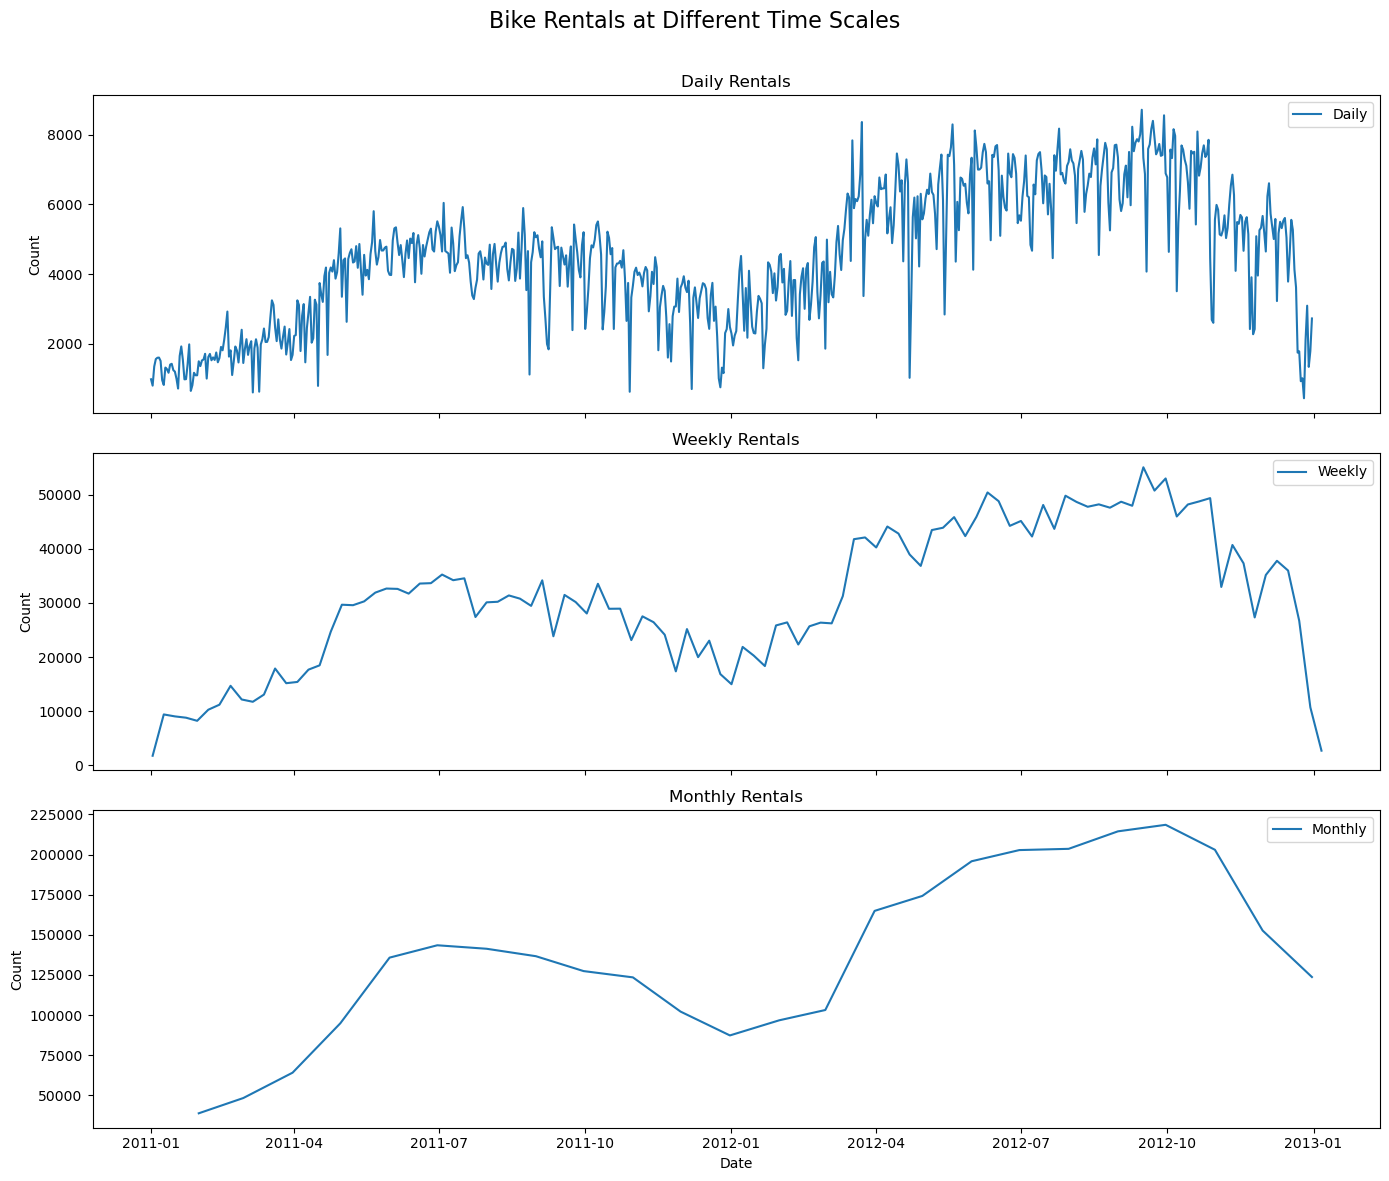

In [28]:
daily_df = df.resample('D').sum()
weekly_df = df.resample('W').sum()
monthly_df = df.resample('ME').sum()  

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle("Bike Rentals at Different Time Scales", fontsize=16)

sns.lineplot(ax=axes[0], x=daily_df.index, y=daily_df['cnt'], label='Daily')
axes[0].set_title('Daily Rentals')
axes[0].set_ylabel('Count')

sns.lineplot(ax=axes[1], x=weekly_df.index, y=weekly_df['cnt'], label='Weekly')
axes[1].set_title('Weekly Rentals')
axes[1].set_ylabel('Count')

sns.lineplot(ax=axes[2], x=monthly_df.index, y=monthly_df['cnt'], label='Monthly')
axes[2].set_title('Monthly Rentals')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Here is different types of resolutions used for the same dataset. Monthly or weekly doesn't show us the most precise picutre, neither does hourly version, so let's take the daily rentals data and do decomposition to check out our components separately

Before we do the decomposition, let's say few things about our time series. So obviously bike rent counts have seasonality, which is pretty visible on the daily graph, because number of rentings definitely will differ between work and rest days. Besides that close fluctuations, we have higher dimension of seasonality because of the seasons, more warm it is, more rents there will be, so we have 2 types of seasonality detected, with no significant trend

For this kind of time seires, I reckon that the best decomposition would be STL, because it is flexible, it can handle two distinc seasonal patterns and it is in general good practice for rental datasets

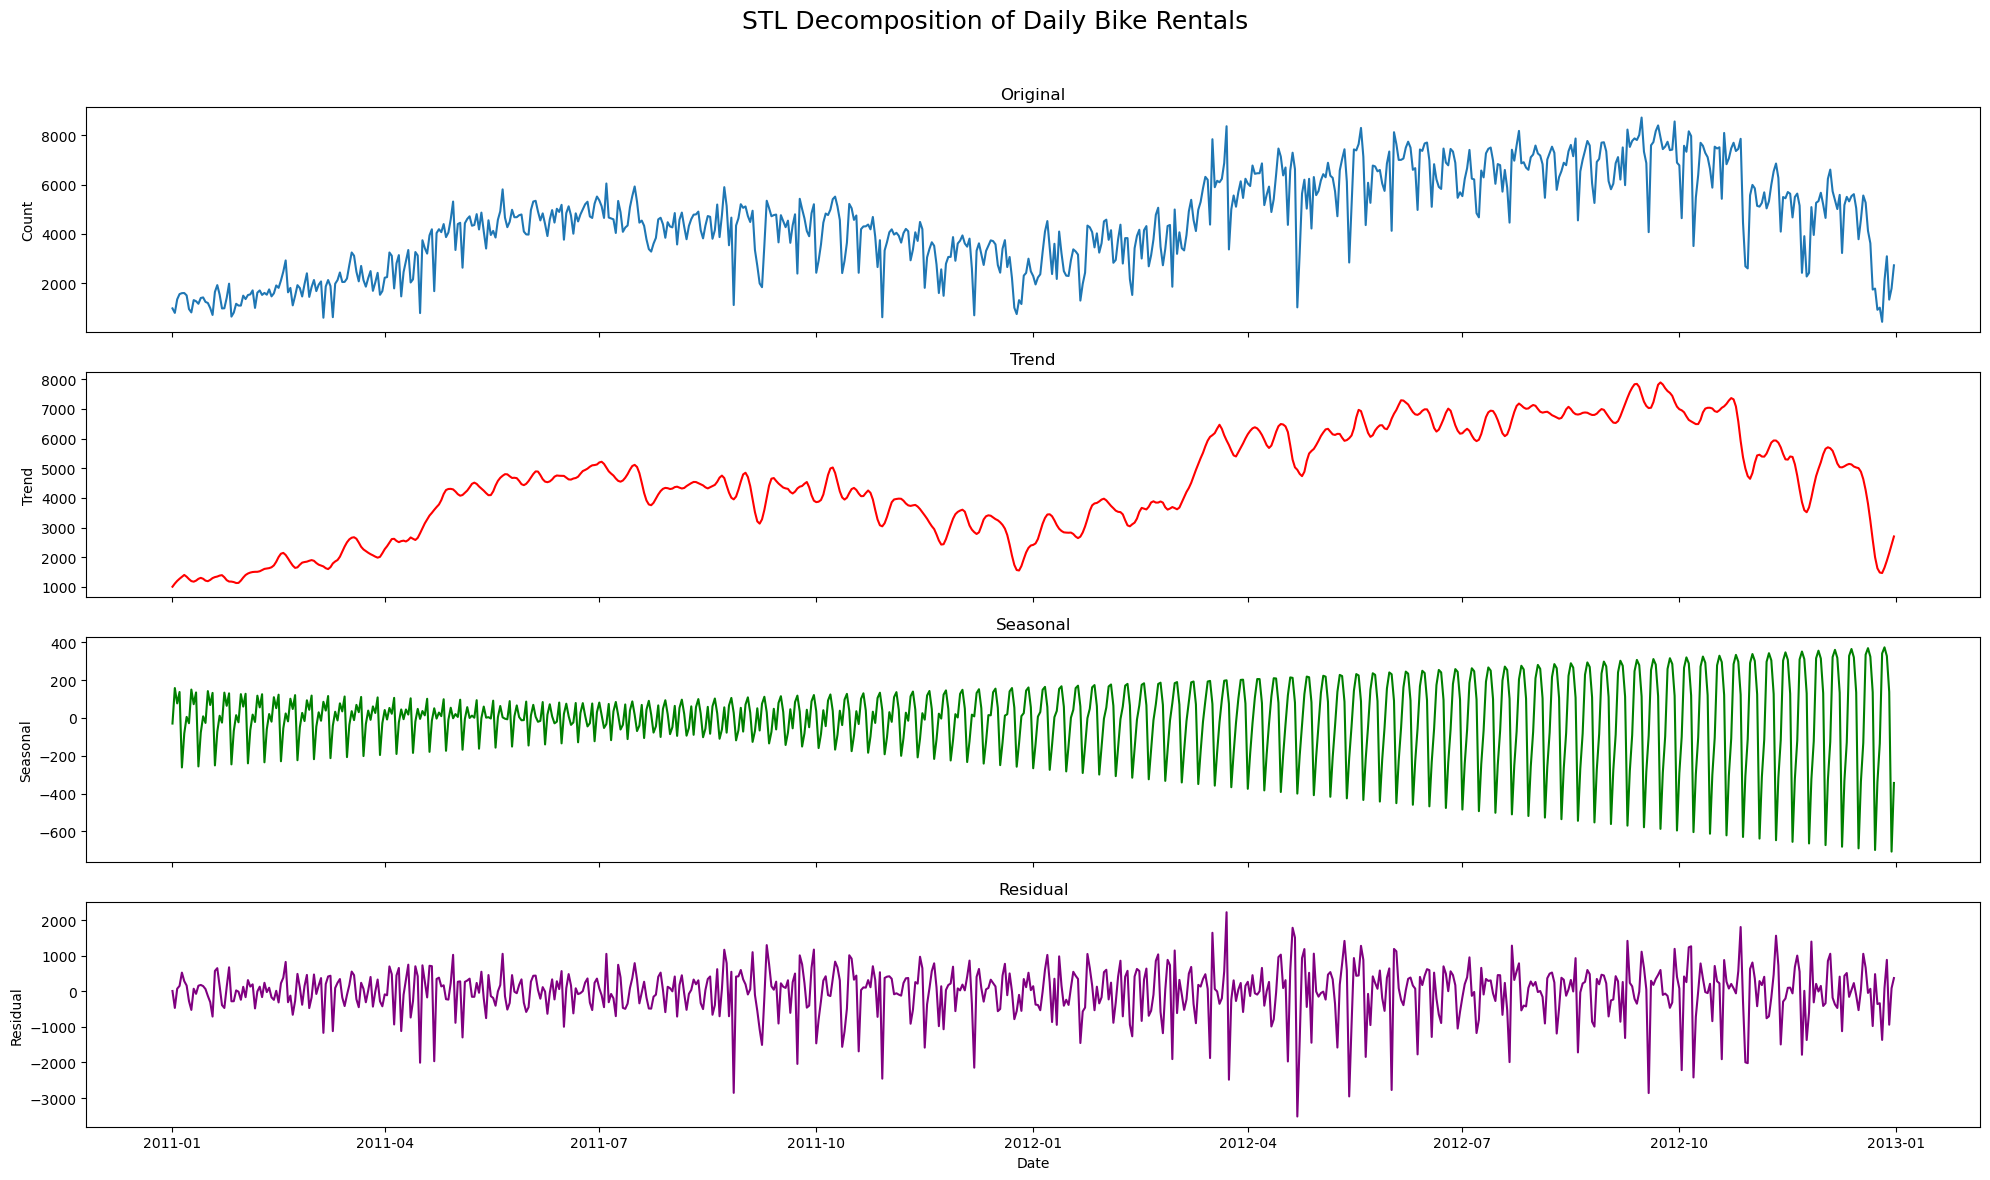

In [32]:
df_daily = df.resample('D').sum()

stl = STL(df_daily['cnt'], seasonal=365, period=7)
result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)
fig.suptitle("STL Decomposition of Daily Bike Rentals", fontsize=18)

sns.lineplot(ax=axes[0], x=df_daily.index, y=df_daily['cnt'])
axes[0].set_title('Original')
axes[0].set_ylabel('Count')

sns.lineplot(ax=axes[1], x=df_daily.index, y=result.trend, color='red')
axes[1].set_title('Trend')
axes[1].set_ylabel('Trend')

sns.lineplot(ax=axes[2], x=df_daily.index, y=result.seasonal, color='green')
axes[2].set_title('Seasonal')
axes[2].set_ylabel('Seasonal')

sns.lineplot(ax=axes[3], x=df_daily.index, y=result.resid, color='purple')
axes[3].set_title('Residual')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

So as we can see, on the trend part there is no much of a trend rather than seasonal changes due to weather conditions directly affect the bike rent counts. on the seasonal plot if we take a closer look to any particular time period, we can see that we have weekly seasonality, which shows us that on the weekends rents go up and during the work days its lower, and it fluctuates throughout the whole time series data we have.

To understand our time series more deeply and know its full spectre of characteristics, we should conduct some statistical tests that will tell us even more about it, more than these plots tell us. Before any tests, let's check out the ACF plot

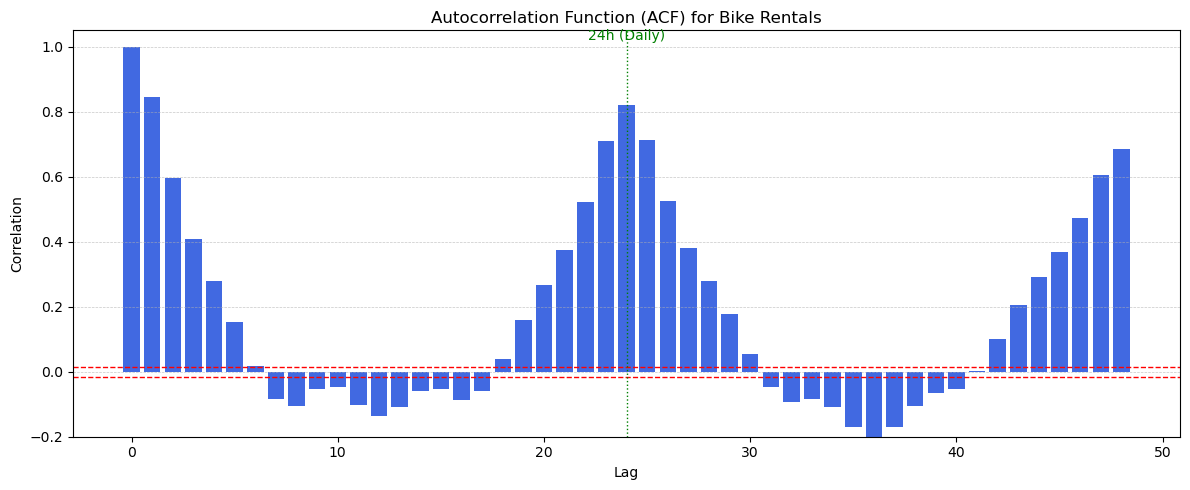

In [35]:
lags = 48
acf_values = acf(df['cnt'].dropna(), nlags=lags)
conf_int = 1.96 / np.sqrt(len(df['cnt'].dropna()))

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(acf_values)), acf_values, color='royalblue')

plt.axhline(conf_int, color='red', linestyle='--', linewidth=1, label='Upper CI')
plt.axhline(-conf_int, color='red', linestyle='--', linewidth=1, label='Lower CI')

if lags >= 24:
    plt.axvline(24, color='green', linestyle=':', linewidth=1)
    plt.text(24, 1.02, '24h (Daily)', color='green', ha='center')

if lags >= 168:
    plt.axvline(168, color='purple', linestyle=':', linewidth=1)
    plt.text(168, 1.02, '168h (Weekly)', color='purple', ha='center')

plt.title("Autocorrelation Function (ACF) for Bike Rentals")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.ylim(-0.2, 1.05)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Based on our Autocorrelation plot, we can assume that we have strong daily seasonality with a peak lag at 24h, confirming that bike rental patterns repeat every 25 hours. High correlation at lag 1 tells us strong hour-to-hour dependence. Negative correlations between peaks suggest opposing rental behaviours at different times of day. This plot confirms both daily and weekly seasonality in the data, which should be incorporated into forecasting models like SARIMA with seasonal periods of 24 and 168 hours.

Now let's find out if our time series is stationary

In [38]:
result = adfuller(df['cnt'].dropna())

print("# Augmented Dickey-Fuller Test Results\n")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print("Critical Values:")
print(f"    1%: {result[4]['1%']:.4f}")
print(f"    5%: {result[4]['5%']:.4f}")
print(f"    10%: {result[4]['10%']:.4f}")
print("\n" + ("Series is stationary (p-value < 0.05)" if result[1] < 0.05 else "Series is non-stationary (p-value >= 0.05)"))

# Augmented Dickey-Fuller Test Results

ADF Statistic: -6.7378
p-value: 0.0000
Critical Values:
    1%: -3.4307
    5%: -2.8617
    10%: -2.5669

Series is stationary (p-value < 0.05)


So our p value turns out to be less than 0.05, which makes our series stationary, which is a good news for the models that we are going to use

In [40]:
time_trend = np.arange(len(df))

X = sm.add_constant(time_trend)
model = sm.OLS(df['cnt'].values, X).fit()

residuals = model.resid

bp_test = het_breuschpagan(residuals, X)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
test_results = dict(zip(labels, bp_test))

print("# Breusch-Pagan Test for Heteroskedasticity\n")
print(f"LM Statistic: {test_results['LM Statistic']:.4f}")
print(f"LM-Test p-value: {test_results['LM-Test p-value']:.4f}")
print(f"F-Statistic: {test_results['F-Statistic']:.4f}")
print(f"F-Test p-value: {test_results['F-Test p-value']:.4f}")
print("\nInterpretation:")
if test_results['LM-Test p-value'] < 0.05:
    print("Reject null hypothesis - Heteroskedasticity detected (p-value < 0.05)")
else:
    print("Fail to reject null hypothesis - No significant heteroskedasticity (p-value >= 0.05)")

# Breusch-Pagan Test for Heteroskedasticity

LM Statistic: 1239.9461
LM-Test p-value: 0.0000
F-Statistic: 1334.0936
F-Test p-value: 0.0000

Interpretation:
Reject null hypothesis - Heteroskedasticity detected (p-value < 0.05)


Breusch-Pagan test's F and LM test both gives us p values less than 0.05, which makes our seires heteroskedastic as well, which also is good for forecasting, because having a constant variance makes forecasting much more reliable and stable

**Let's make an ultimate analysis of our results**:
- Dataset has strong weekly fluctuations
- It also has noticable seasonality through seasons
- It has strong correlation between 24h intervals
- It has negative correlation between 12h intervals
- Our data is stationary
- It also is heteroskedastic (has constan variance)

Time to do model benchmarking and evaluation to get the best possible forecasts

## **Forecasting and Evaluation**

### Seasonal NAIVE (baseline)

Firstly, we should make our baseline model, which I will choose to be SNAIVE, because our data's strong seasonality I believe that it should give us the best results out of other simple forecasting methods. For evaluation metrics I will choose the following three:
- MASE (Mean Absolute Scaled Error): This metric allows us to compare the model's forecast errors relative to a naive baseline, making it particularly useful for time-series data. It accounts for scale differences and is robust to outliers, making it a good indicator of overall model performance.

- RMSE (Root Mean Squared Error): RMSE gives a sense of the average magnitude of forecast errors. It penalizes larger errors more than smaller ones, helping to assess the model’s performance in capturing the overall pattern of data.

- WAPE (Weighted Absolute Percentage Error): WAPE is the percentage error, weighted by the actual values, providing insight into how well the model is performing relative to the actual values. It’s particularly useful when we want to understand the forecast errors as a percentage of the actual demand.

with these three metrics I believe we can track all the different aspects of our forecasting models. I also could change my mind throughout the forecasting and change one of them or even change after I do the other models, but at the first glance these 3 seem the most appropriate ones at the moment. Let's also mention that I am going to do the forecasts for 3 different time horizons: 1 day, 1 week and 1 Month forecasts and find out their results


Evaluation metrics for SNAIVE 1-Day:
MASE: 0.6192
RMSE: 42.2936
WAPE (%): 15.9826

Evaluation metrics for SNAIVE 1-Week:
MASE: 1.6168
RMSE: 140.0690
WAPE (%): 36.8229

Evaluation metrics for SNAIVE 1-Month:
MASE: 2.0640
RMSE: 175.0855
WAPE (%): 44.1044


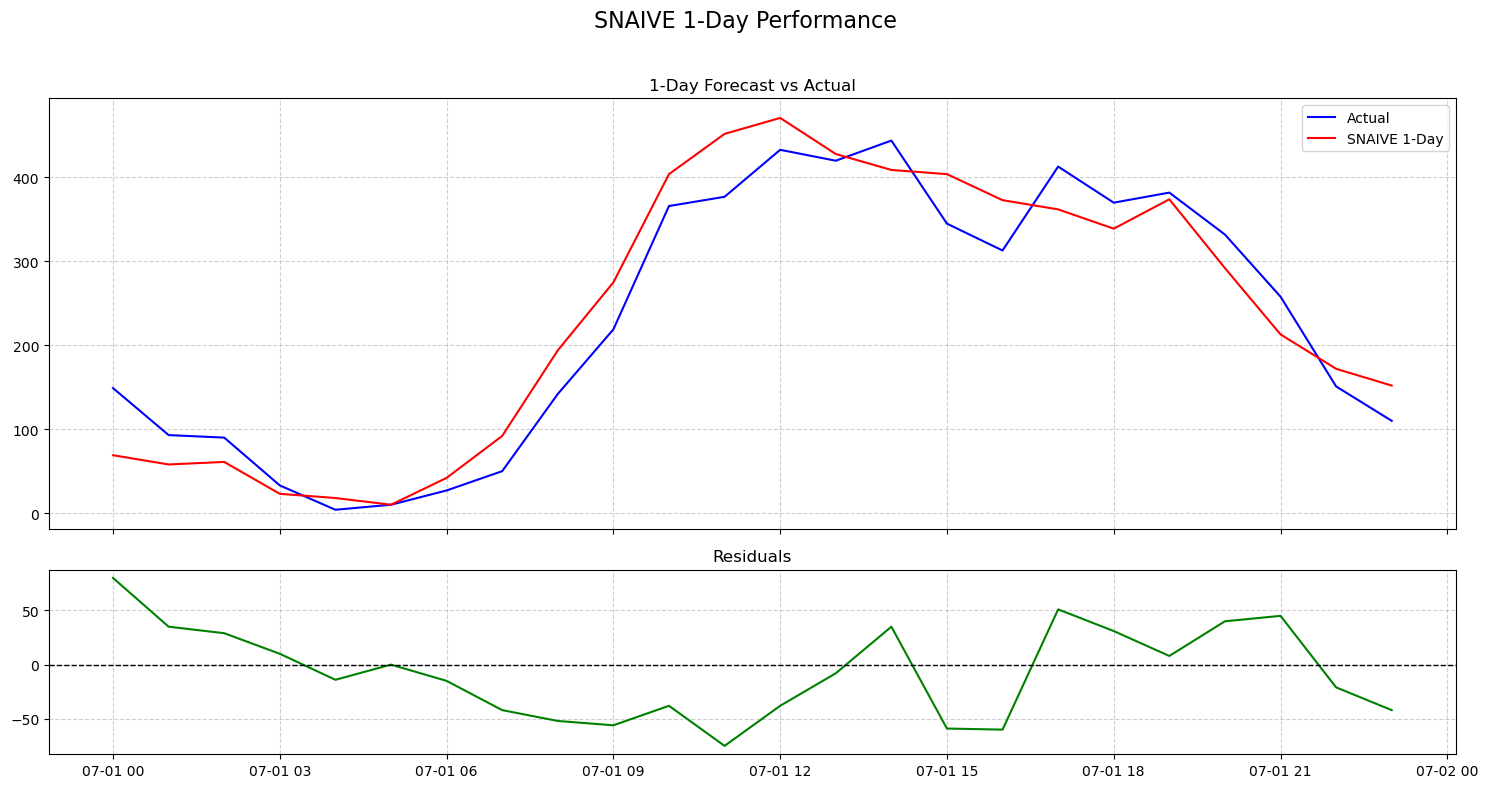

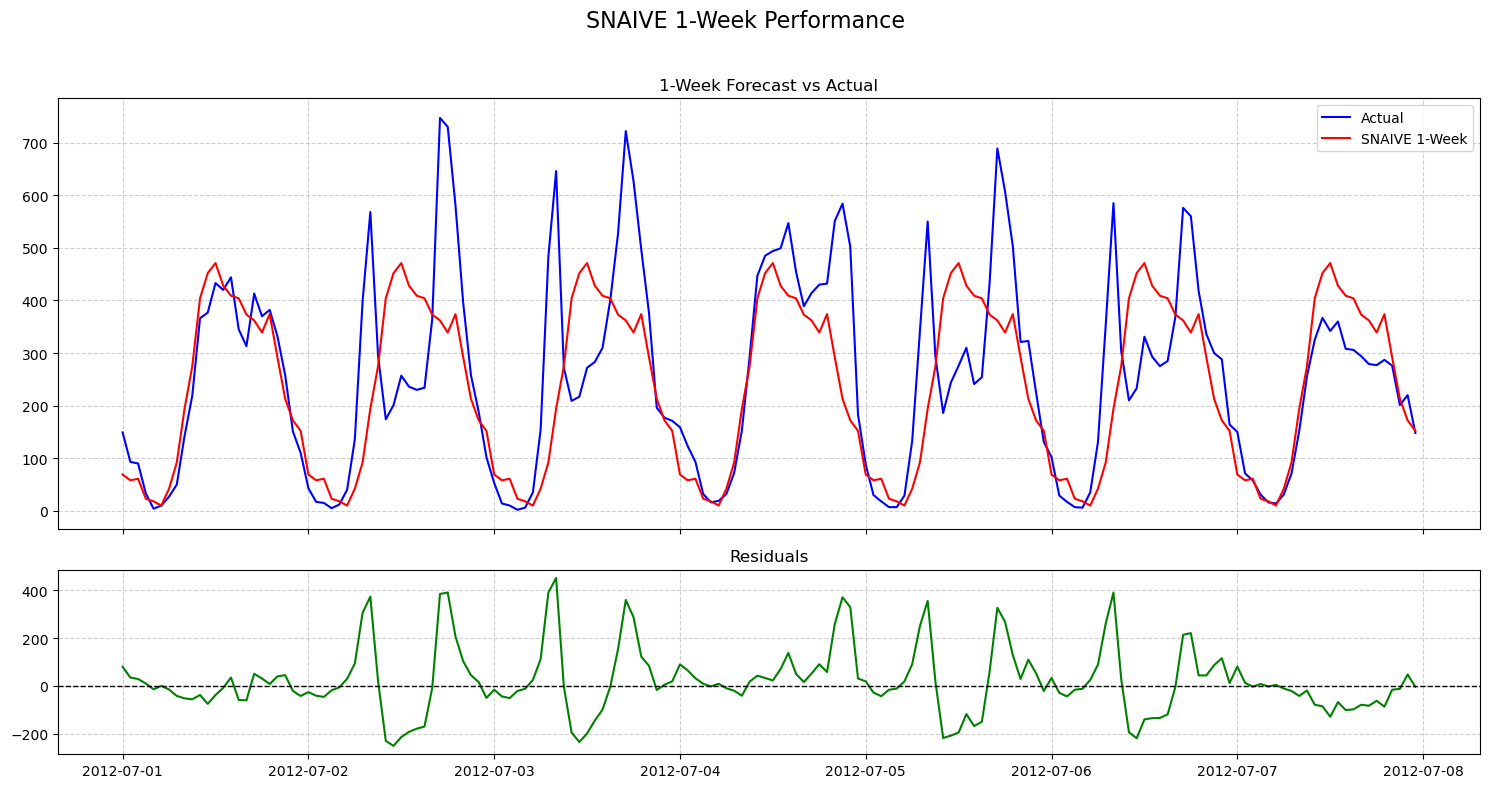

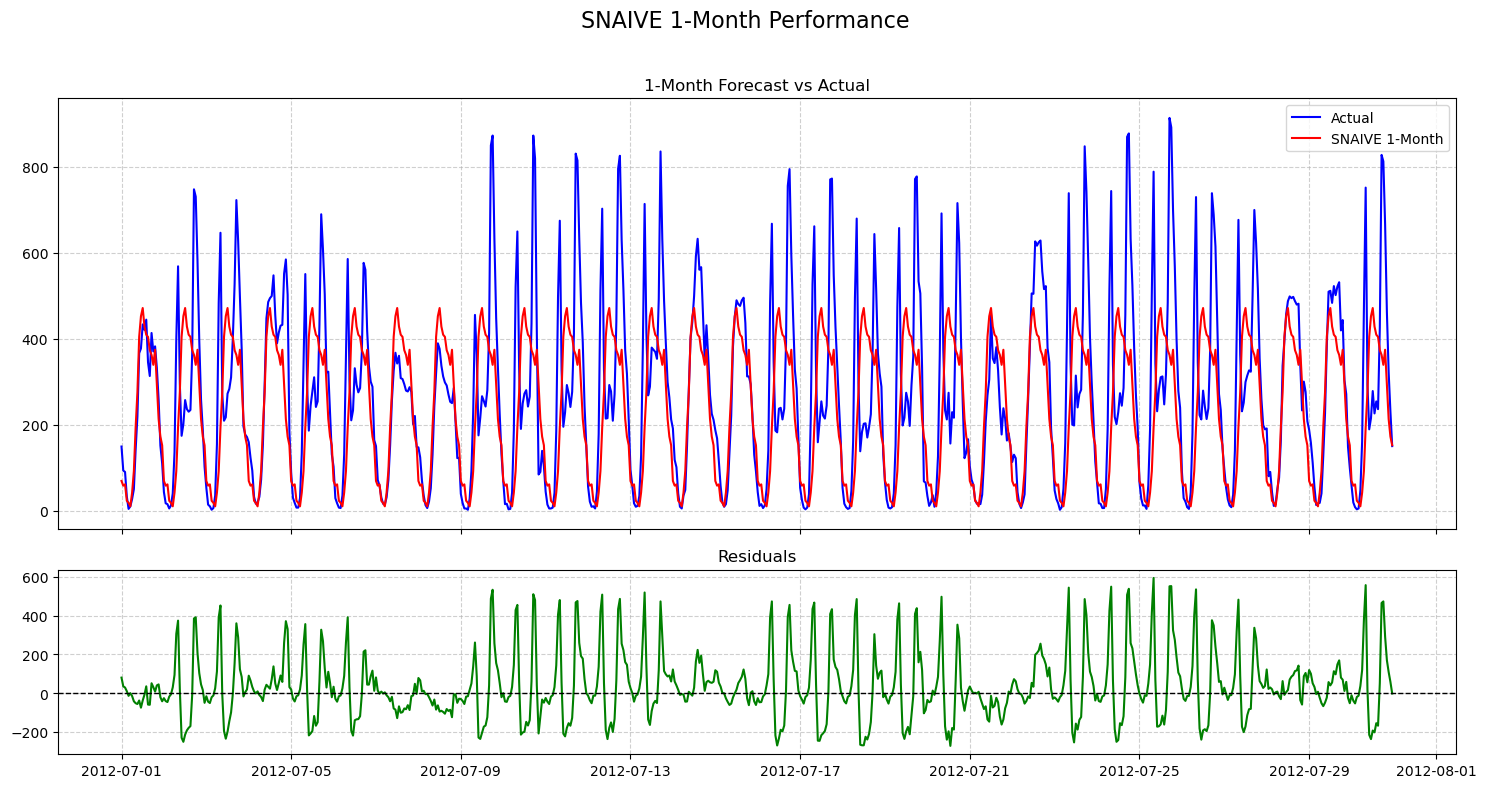

In [47]:
def split_data(df):
    split_date = df.index.max() - pd.DateOffset(months=6)
    train = df.loc[df.index <= split_date]
    test = df.loc[df.index > split_date]
    return train, test

def snaive_forecast(train, test, seasonality=24):
    forecast = pd.DataFrame(index=test.index, columns=['snaive_forecast'])
    for i, idx in enumerate(test.index):
        forecast_idx = idx - pd.Timedelta(hours=seasonality)
        if forecast_idx in train.index:
            forecast.loc[idx, 'snaive_forecast'] = train.loc[forecast_idx, 'cnt']
        else:
            forecast_idx_in_test = idx - pd.Timedelta(hours=seasonality)
            if forecast_idx_in_test in forecast.index:
                forecast.loc[idx, 'snaive_forecast'] = forecast.loc[forecast_idx_in_test, 'snaive_forecast']
            else:
                forecast.loc[idx, 'snaive_forecast'] = train['cnt'].mean()
    return forecast

def evaluate_forecast(actual, forecast, model_name="Model", train=None, seasonality=24):
    actual = actual.values
    forecast = forecast.values

    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    wape = np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100

    if train is not None:
        naive_forecast = train['cnt'].shift(seasonality)
        mase_denom = np.mean(np.abs(train['cnt'][seasonality:] - naive_forecast[seasonality:]))
        mase = mae / mase_denom if mase_denom != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MASE": mase,
        "RMSE": rmse,
        "WAPE (%)": wape
    }

    print(f"\nEvaluation metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

def plot_forecast(actual, forecast, title="Forecast vs Actual", model_name="Model"):
    residuals = actual - forecast

    fig, axes = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [0.7, 0.3]}, sharex=True)
    
    axes[0].plot(actual.index, actual, label='Actual', color='blue')
    axes[0].plot(forecast.index, forecast, label=model_name, color='red')
    axes[0].set_title(title)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].plot(residuals.index, residuals, label='Residuals', color='green')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_title('Residuals')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f"{model_name} Performance", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
train, test = split_data(df)

forecast_1day_n = snaive_forecast(train, test.iloc[:24], seasonality=24)
forecast_1week_n = snaive_forecast(train, test.iloc[:168], seasonality=24)
forecast_1month_n = snaive_forecast(train, test.iloc[:720], seasonality=24)

metrics_1day_n = evaluate_forecast(test.iloc[:24]['cnt'], forecast_1day_n['snaive_forecast'],
                                 "SNAIVE 1-Day", train=train, seasonality=24)

metrics_1week_n = evaluate_forecast(test.iloc[:168]['cnt'], forecast_1week_n['snaive_forecast'],
                                  "SNAIVE 1-Week", train=train, seasonality=24)

metrics_1month_n = evaluate_forecast(test.iloc[:720]['cnt'], forecast_1month_n['snaive_forecast'],
                                   "SNAIVE 1-Month", train=train, seasonality=24)

plot_forecast(test.iloc[:24]['cnt'], forecast_1day_n['snaive_forecast'],
                      title="1-Day Forecast vs Actual", model_name="SNAIVE 1-Day")

plot_forecast(test.iloc[:168]['cnt'], forecast_1week_n['snaive_forecast'],
                      title="1-Week Forecast vs Actual", model_name="SNAIVE 1-Week")

plot_forecast(test.iloc[:720]['cnt'], forecast_1month_n['snaive_forecast'],
                      title="1-Month Forecast vs Actual", model_name="SNAIVE 1-Month")

To conclude our results briefly our baseline model shows a clear decrease in performance as the forecasting horizon increases. It performs best for the 1-day forecast, where its MASE, RMSE, and WAPE values suggest a fairly good fit to the actual data. However, for the 1-week and 1-month forecasts, the model’s performance degrades significantly, with larger forecast errors (especially in terms of RMSE and WAPE), reflecting the difficulty in capturing long-term fluctuations and seasonality in the data. These results suggest that while the SNAIVE model is adequate for short-term forecasts, it may not be sufficient for longer-term predictions

### Seasonal ARIMA

Now since we have the baseline model's results, we can build more complex models for comparison and yield much better results hopefully. Based on the dataset we have, I will stick to the SARIMA at first and I will also try out Facebook Prophet, both of them are good with seasonality, prophet is good especially with multiple seasonalities and SARIMA works well with stationart times series.


Evaluation metrics for SARIMA 1-Day:
MASE: 1.7807
RMSE: 143.2193
WAPE (%): 44.9243

Evaluation metrics for SARIMA 1-Week:
MASE: 1.4605
RMSE: 117.5542
WAPE (%): 33.0924

Evaluation metrics for SARIMA 1-Month:
MASE: 1.6459
RMSE: 125.1161
WAPE (%): 35.0827


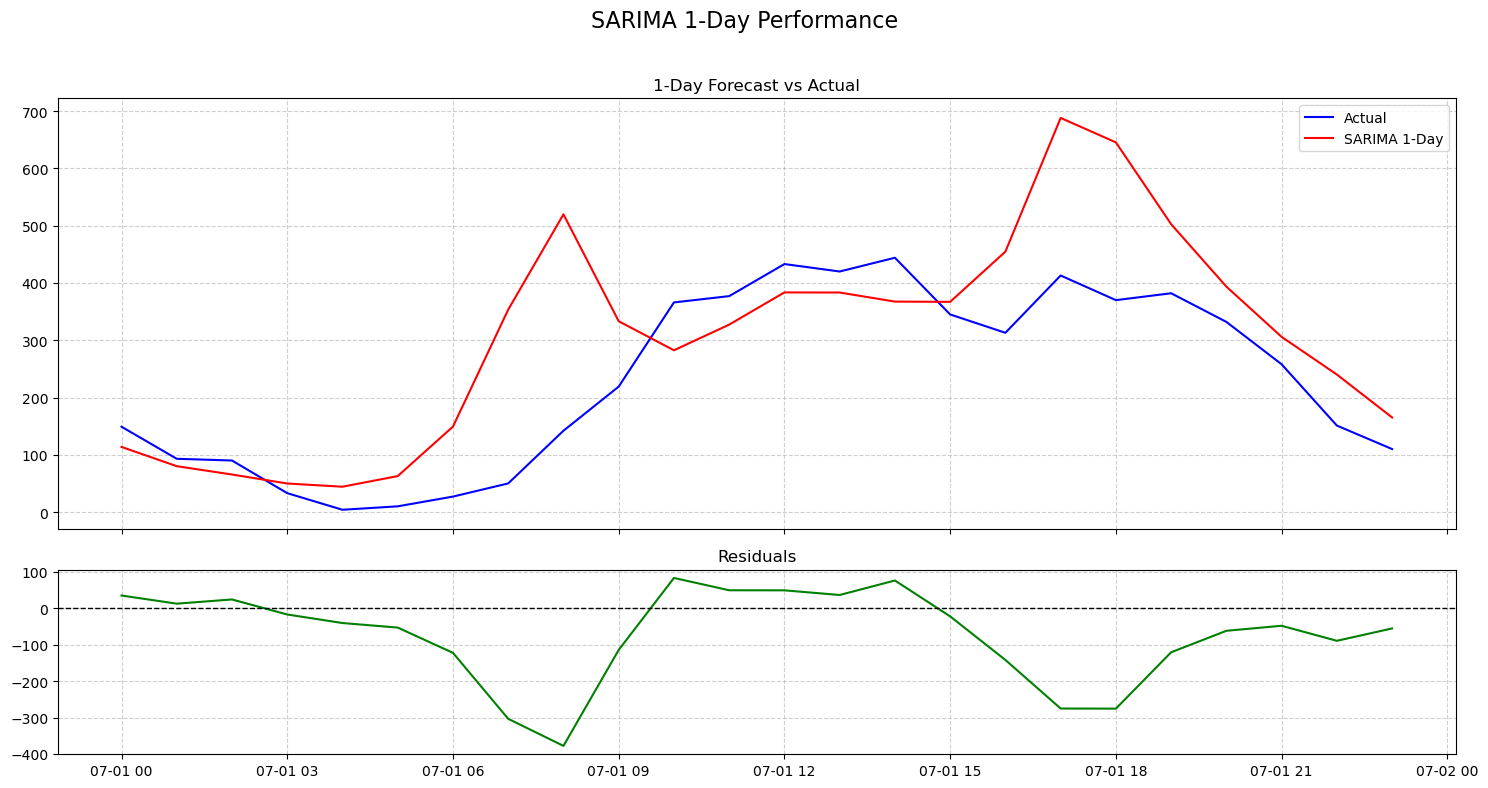

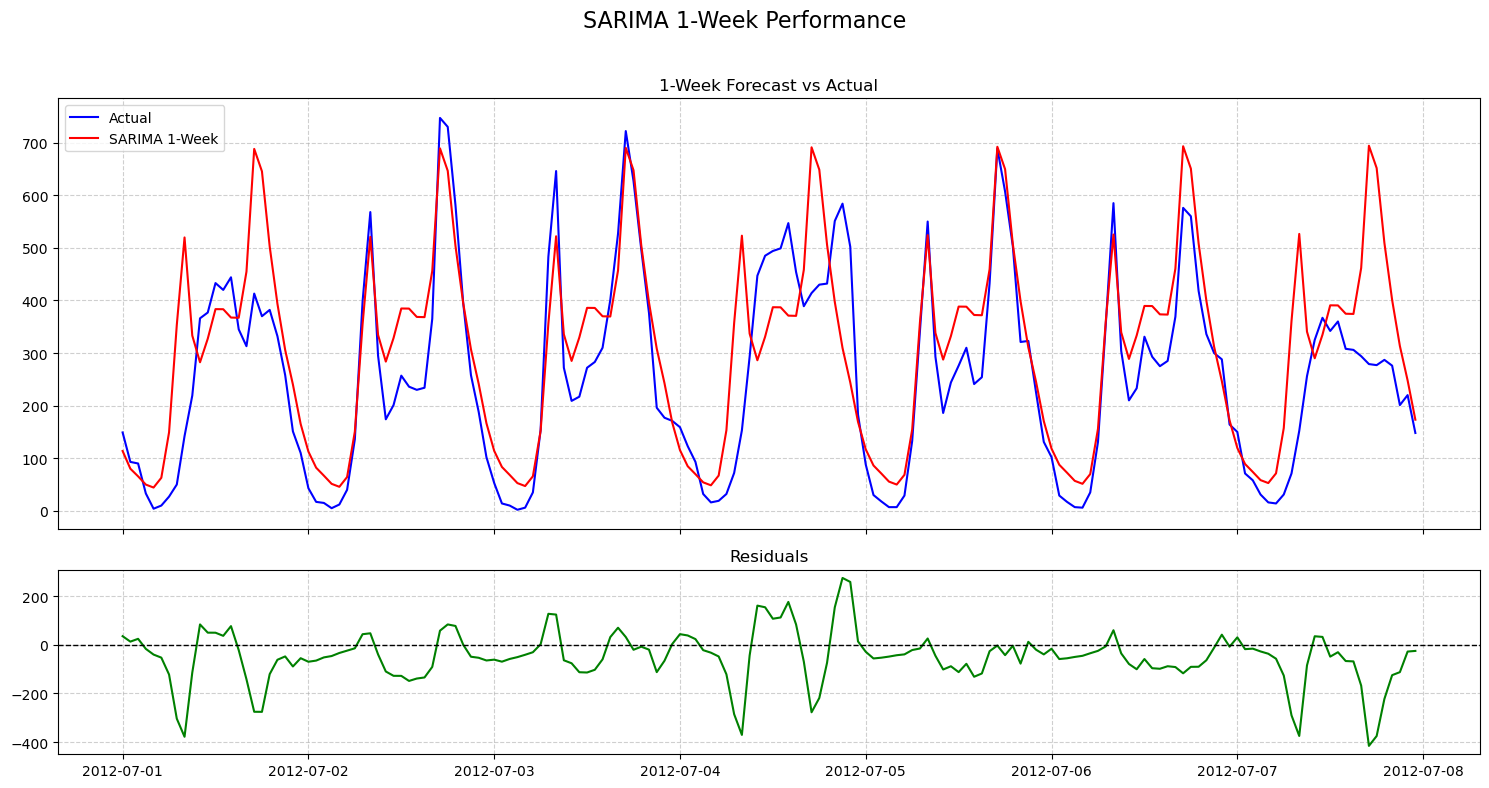

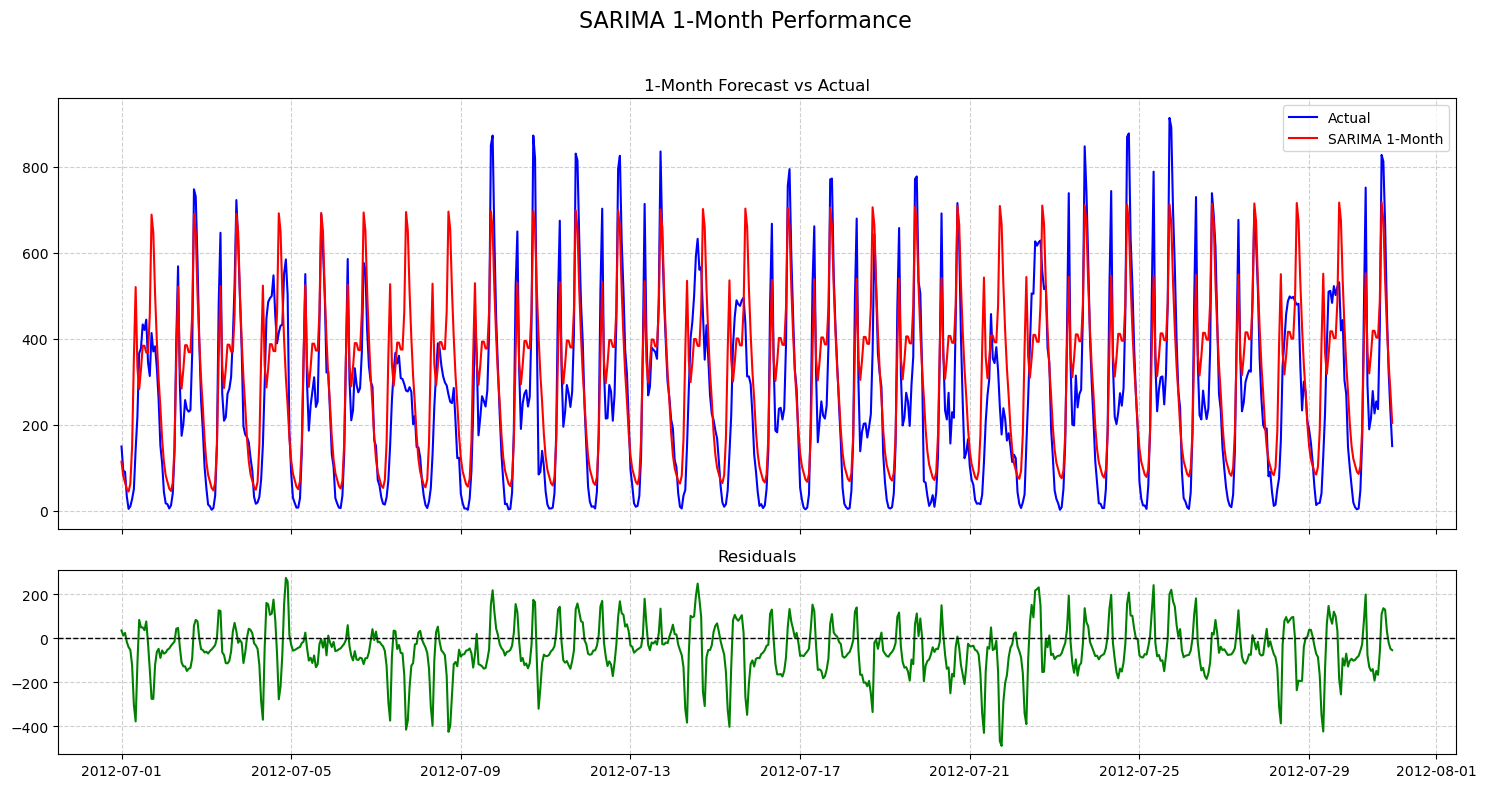

In [51]:
def sarima_forecast(train, test, order=(1, 1, 1), seasonal_order=(1, 0, 1, 24)):
    sarima_model = SARIMAX(train['cnt'], order=order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit(disp=False)

    forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean

    forecast = pd.Series(forecast.values, index=test.index, name='sarima_forecast')
    return forecast, sarima_fit

def evaluate_forecast(actual, forecast, model_name="Model", train=None, seasonality=24):
    actual = actual.values
    forecast = forecast.values

    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    wape = np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100

    if train is not None:
        naive_forecast = train['cnt'].shift(seasonality)
        mase_denom = np.mean(np.abs(train['cnt'][seasonality:] - naive_forecast[seasonality:]))
        mase = mae / mase_denom if mase_denom != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MASE": mase,
        "RMSE": rmse,
        "WAPE (%)": wape
    }

    print(f"\nEvaluation metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

def plot_forecast(actual, forecast, title="Forecast vs Actual", model_name="Model"):
    residuals = actual - forecast

    fig, axes = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [0.7, 0.3]}, sharex=True)
    
    axes[0].plot(actual.index, actual, label='Actual', color='blue')
    axes[0].plot(forecast.index, forecast, label=model_name, color='red')
    axes[0].set_title(title)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Residuals
    axes[1].plot(residuals.index, residuals, label='Residuals', color='green')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_title('Residuals')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f"{model_name} Performance", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

train, test = split_data(df)

forecast_1day_r, model_1day_r = sarima_forecast(train, test.iloc[:24], order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))
forecast_1week_r, model_1week_r = sarima_forecast(train, test.iloc[:168], order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))
forecast_1month_r, model_1month_r = sarima_forecast(train, test.iloc[:720], order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))

metrics_1day_r = evaluate_forecast(test.iloc[:24]['cnt'], forecast_1day_r, "SARIMA 1-Day", train=train, seasonality=24)
metrics_1week_r = evaluate_forecast(test.iloc[:168]['cnt'], forecast_1week_r, "SARIMA 1-Week", train=train, seasonality=24)
metrics_1month_r = evaluate_forecast(test.iloc[:720]['cnt'], forecast_1month_r, "SARIMA 1-Month", train=train, seasonality=24)

plot_forecast(test.iloc[:24]['cnt'], forecast_1day_r, title="1-Day Forecast vs Actual", model_name="SARIMA 1-Day")
plot_forecast(test.iloc[:168]['cnt'], forecast_1week_r, title="1-Week Forecast vs Actual", model_name="SARIMA 1-Week")
plot_forecast(test.iloc[:720]['cnt'], forecast_1month_r, title="1-Month Forecast vs Actual", model_name="SARIMA 1-Month")

### Facebook Prophet


Evaluation metrics for Prophet 1-Day:
MASE: 1.6701
RMSE: 115.5907
WAPE (%): 42.1340

Evaluation metrics for Prophet 1-Week:
MASE: 1.8075
RMSE: 124.7398
WAPE (%): 40.9538

Evaluation metrics for Prophet 1-Month:
MASE: 2.0738
RMSE: 145.1909
WAPE (%): 44.2035


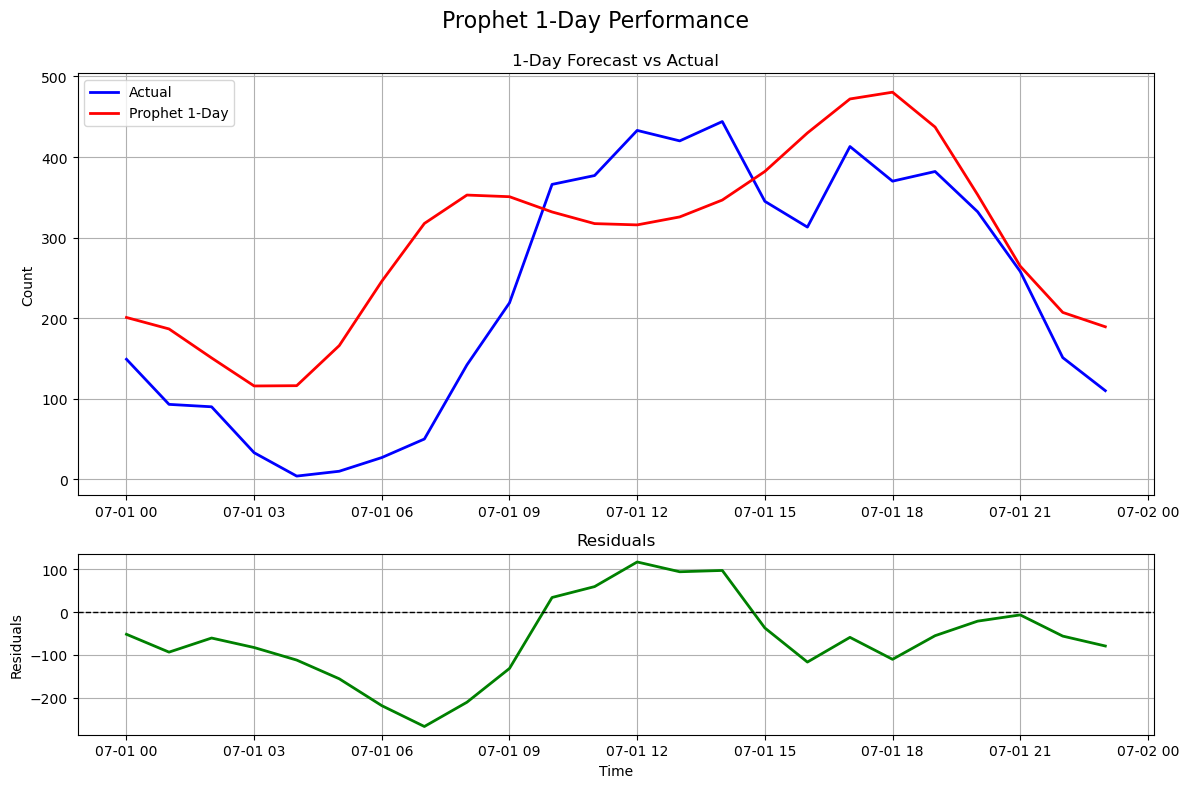

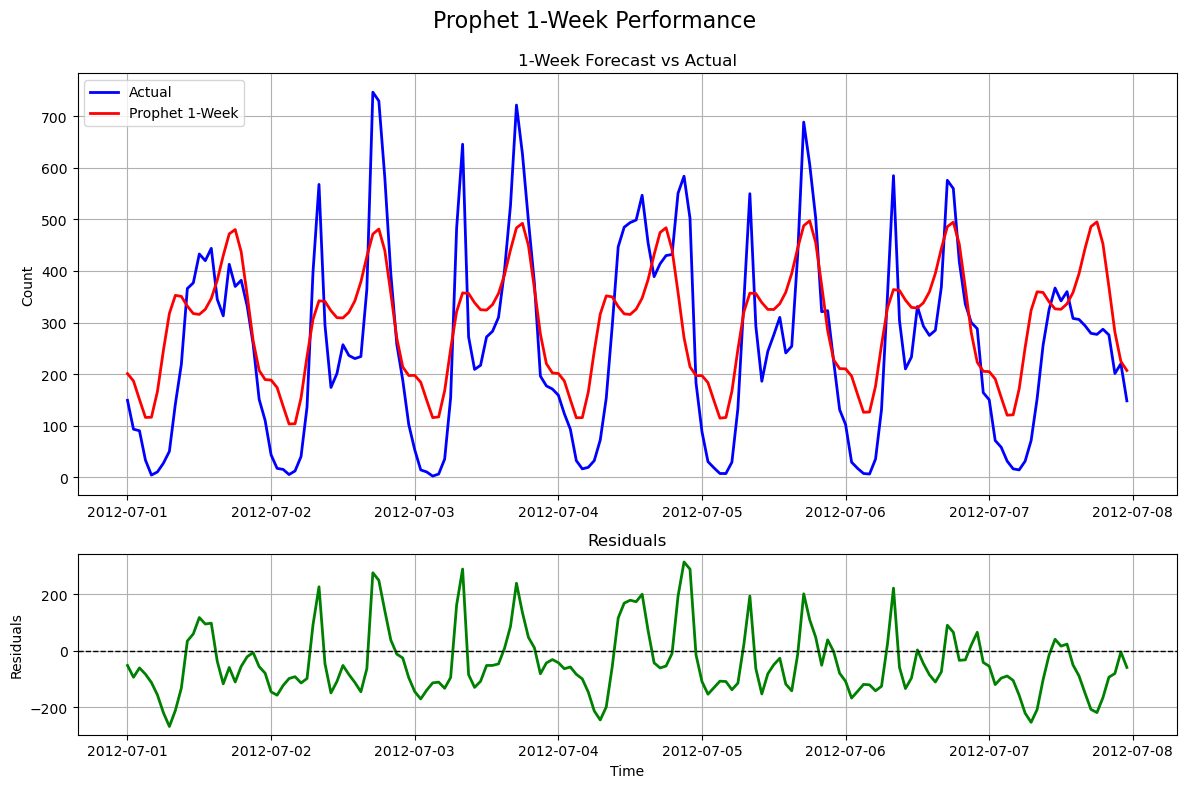

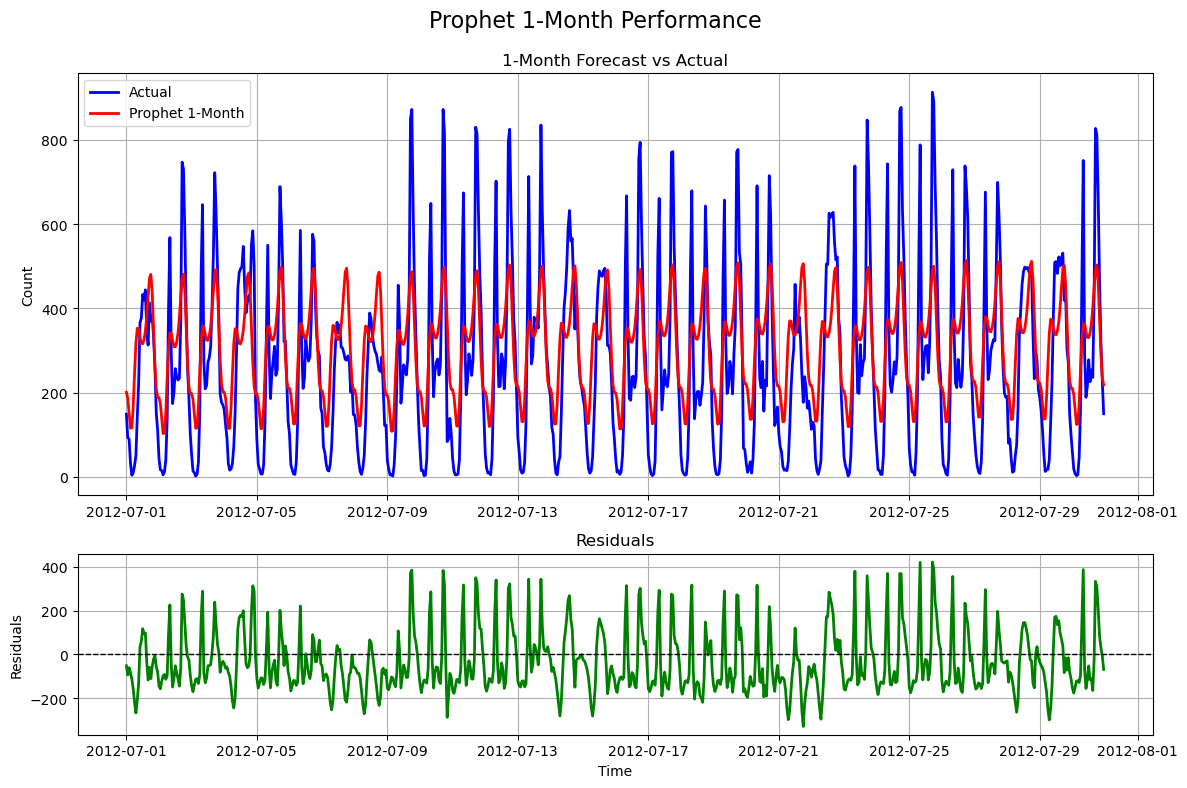

In [102]:
def prepare_data_for_prophet(df):
    df_prepared = df.reset_index().rename(columns={'datetime': 'ds', 'cnt': 'y'})
    return df_prepared

def prophet_forecast(train, test):
    train_prophet = prepare_data_for_prophet(train)

    model = Prophet()
    model.fit(train_prophet)

    future = pd.DataFrame({'ds': test.index})

    forecast = model.predict(future)

    forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': 'prophet_forecast'})
    forecast.set_index('ds', inplace=True)

    return forecast, model

def evaluate_forecast(actual, forecast, model_name="Model", train=None, seasonality=24):
    actual = actual.values
    forecast = forecast.values

    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    wape = np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100

    if train is not None:
        naive_forecast = train['cnt'].shift(seasonality)
        mase_denom = np.mean(np.abs(train['cnt'][seasonality:] - naive_forecast[seasonality:]))
        mase = mae / mase_denom if mase_denom != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MASE": mase,
        "RMSE": rmse,
        "WAPE (%)": wape
    }

    print(f"\nEvaluation metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

def plot_forecast(actual, forecast, title="Forecast vs Actual", model_name="Model"):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [0.7, 0.3]})
    fig.suptitle(f"{model_name} Performance", fontsize=16)

    ax[0].plot(actual.index, actual, label="Actual", color="blue", lw=2)
    ax[0].plot(forecast.index, forecast, label=model_name, color="red", lw=2)
    ax[0].set_title(title)
    ax[0].set_ylabel("Count")
    ax[0].legend(loc="upper left")
    ax[0].grid(True)

    residuals = actual - forecast
    ax[1].plot(residuals.index, residuals, label="Residuals", color="green", lw=2)
    ax[1].axhline(0, color="black", linestyle="--", lw=1)  
    ax[1].set_title("Residuals")
    ax[1].set_ylabel("Residuals")
    ax[1].set_xlabel("Time")
    ax[1].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=UserWarning, module='prophet')
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

train, test = split_data(df)

forecast_1day_p, model_1day_p = prophet_forecast(train, test.iloc[:24])
forecast_1week_p, model_1week_p = prophet_forecast(train, test.iloc[:168])
forecast_1month_p, model_1month_p = prophet_forecast(train, test.iloc[:720])

metrics_1day = evaluate_forecast(test.iloc[:24]['cnt'], forecast_1day_p['prophet_forecast'],
                                 "Prophet 1-Day", train=train)
metrics_1week = evaluate_forecast(test.iloc[:168]['cnt'], forecast_1week_p['prophet_forecast'],
                                  "Prophet 1-Week", train=train)
metrics_1month = evaluate_forecast(test.iloc[:720]['cnt'], forecast_1month_p['prophet_forecast'],
                                   "Prophet 1-Month", train=train)

plot_forecast(test.iloc[:24]['cnt'], forecast_1day_p['prophet_forecast'],
                     title="1-Day Forecast vs Actual", model_name="Prophet 1-Day")

plot_forecast(test.iloc[:168]['cnt'], forecast_1week_p['prophet_forecast'],
                     title="1-Week Forecast vs Actual", model_name="Prophet 1-Week")

plot_forecast(test.iloc[:720]['cnt'], forecast_1month_p['prophet_forecast'],
                     title="1-Month Forecast vs Actual", model_name="Prophet 1-Month")

Okay now let's wrap all up and compare our metrics to each other until we conduct residual analysis for further comparisons. So for 1 day forecasts SNAIVE is the clear winner here, achieving the lowesr errors across MASE, RMSE and WAPE. Both SARIMA and Prophet perform worse in this horizon. For 1 week of 1 month forecasts SARIMA outperforms SNAIVE and Prophet, capturins seasonal and trend components better for medium and long term time horizons. Prophet performs poorly in this case because we don't have prophet specific optimized data, so proper tuning is essential for prophet in the most cases and it was more likely to yield this kind of performance on the default settings, so we can stick to our other 2 models at the moment

Let's now implement one very interesting metric called RdR score to compare SARIMA and SNAIVE models to each other (1 week). Before comparison I will copy paste the implementation from RdR score's Github, because colab doesn't let me pip install the function

In [56]:
class RdR_scorer:
    def __init__(self):
        return

    def fit(self, ts, y_colname, n_step, y_true, y_pred, model_name = 'MODEL', freq = 12):

        start_date = min(y_true.index)
        end_date = max(y_true.index)

        model1 = sm.tsa.statespace.SARIMAX(ts[y_colname],
                                           order=(0,1,0),
                                           seasonal_order=(0, 0, 0, freq),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False
                                           #exog = exog
                                           #trend='c'
                                           #,time_varying_regression = True
                                           )
        model1 = model1.fit(method = 'lbfgs')

        RandomWalkPred = model1.get_prediction(start=start_date,
                                               end=end_date,
                                               dynamic=False)
        pred_ci2 = RandomWalkPred.conf_int()
        y_forecasted = pd.DataFrame(RandomWalkPred.predicted_mean).astype(float)
        RandomWalkPred = pd.concat([y_forecasted, pred_ci2.astype(float)], axis = 1)
        RandomWalkPred.columns = ['Y_PRED', 'Y_PRED_LOWER', 'Y_PRED_UPPER']
        RandomWalkPred.index = pd.to_datetime(RandomWalkPred.index)

        rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))
        dtw_distance_model = dtw.distance(y_true.values, y_pred.values)

        rmse_rw = np.sqrt(mean_squared_error(y_true, RandomWalkPred['Y_PRED']))
        dtw_distance_rw = dtw.distance(y_true.values, RandomWalkPred['Y_PRED'].values)

        rmse_scaler = MinMaxScaler(feature_range = (0,1))
        dtw_scaler = MinMaxScaler(feature_range = (0,1))

        df_scale = pd.DataFrame([[0, 0],[ rmse_rw, dtw_distance_rw]])
        df_scale.columns = ['RMSE','DTW']
        df_scale['RMSE_SCORE'] = 1 - rmse_scaler.fit_transform(df_scale[['RMSE']].values).ravel()
        df_scale['DTW_SCORE'] = 1 - dtw_scaler.fit_transform(df_scale[['DTW']].values).ravel()
        df_scale['RdR_SCORE'] = (df_scale['RMSE_SCORE'] + df_scale['DTW_SCORE']) / 2

        df = pd.DataFrame([[rmse_model, dtw_distance_model]])
        df.columns = ['RMSE','DTW']
        df['RMSE_SCORE'] = 1 - rmse_scaler.transform(df[['RMSE']].values).ravel()
        df['DTW_SCORE'] = 1 - dtw_scaler.transform(df[['DTW']].values).ravel()
        df['RdR_SCORE'] = (df['RMSE_SCORE'] + df['DTW_SCORE']) / 2

        df_all = pd.concat([df_scale, df], axis = 0, ignore_index = True).reset_index(drop = True)

        rmse_pourc = y_true.copy()
        rmse_pourc['RMSE_POURC'] = df['RMSE'].values / rmse_pourc[y_colname].values
        rmse_pourc['RMSE_ACCURACY'] = 1 - (df['RMSE'].values / rmse_pourc[y_colname].values)
        rmse_pourc['RMSE_ACCURACY'].clip(lower = 0)
        forecast_accuracy_mean = rmse_pourc['RMSE_ACCURACY'].mean()
        forecast_accuracy_min = rmse_pourc['RMSE_ACCURACY'].min()
        forecast_accuracy_max = rmse_pourc['RMSE_ACCURACY'].max()

        self._rmse = df['RMSE'].values[0]
        self._dtw = df['DTW'].values[0]
        self._rdr = df['RdR_SCORE'].values[0]

        self._rmse_rw = df_scale['RMSE'].values[0]
        self._dtw_rw = df_scale['DTW'].values[0]
        self._rdr_rw = df_scale['RdR_SCORE'].values[0]

        self._model_df = df[['DTW', 'RMSE', 'RdR_SCORE']]
        self._model_df['MODEL_NAME'] = str(model_name)
        self._rw_df = df_scale.loc[df_scale['RMSE'] > 0][['DTW', 'RMSE', 'RdR_SCORE']]
        self._rw_df['MODEL_NAME'] = 'RandomWalk'
        self._all_df = df_all[['DTW', 'RMSE']]

        self._pred_rw = RandomWalkPred

        self._fa_mean = forecast_accuracy_mean
        self._fa_min = forecast_accuracy_min
        self._fa_max = forecast_accuracy_max


        self._def_viz = pd.concat([self._model_df, self._rw_df], axis = 0, ignore_index = True).reset_index(drop = True)


    def score(self):
        return self._rdr

    def get_rmse_score(self):
        return self._rmse

    def get_dtw_score(self):
        return self._dtw

    def get_randomwalk_rmse_score(self):
        return self._rmse_rw

    def get_randomwalk_dtw_score(self):
        return self._dtw_rw

    def get_randomwalk_pred(self):
        return self._pred_rw

    def get_df_viz(self):
        return self._def_viz

    def add_rdr(self, rdr_object):
        self._def_viz = pd.concat([self._def_viz, rdr_object._def_viz], axis = 0, ignore_index = True).reset_index(drop = True)
        self._def_viz = self._def_viz.drop_duplicates()
        return self._def_viz

    def get_rdr_interpretation(self):
        if self._rdr > 0 and self._fa_mean >= 0.75:
            qual = 'GOOD PERFORMANCE'
        elif self._rdr > 0 and self._fa_mean < 0.75:
            qual = 'AVERAGE PERFORMANCE'
        elif self._rdr < 0:
            qual = 'BAD PEFORMANCE'
        else:
            pass

        if self._rdr > 0 :
            trust = 'better'
        elif self._rdr == 0:
            trust = '(equal)'
        else:
            trust = 'worst'

        texte = qual + ': ' + 'With a stable trend and no major unpredictable changes, the model is ' + str(round((self._rdr * 100), 2)) + '% ' + trust + ' than a naïve random decision. The mean forecast accuracy is ' + str(round(self._fa_mean * 100,2)) + '% (around ' + str(round(self._fa_min * 100,2)) + '% and ' + str(round(self._fa_max * 100,2)) + '% of accuracy per forecasted datapoint)'

        return texte

    def plot_rdr_rank(self, models = list([])):
        if len(models) == 0:
            models = self._def_viz

        models = models.append(pd.DataFrame([[0,0,1.0,'Perfect Score']], index = [max(models.index)+1], columns = models.columns))

        model_ranking = models.sort_values(by = 'RdR_SCORE', ascending = True)
        model_ranking['RdR_SCORE'] = model_ranking['RdR_SCORE'] * 100
        #model_ranking = model_ranking.loc[~model_ranking['MODEL_NAME'].isin(['PERFECT_SCORE', 'WORST_SCORE'])]

        colors = []
        for value in model_ranking.loc[:, 'RdR_SCORE']: # keys are the names of the boys
            if value < 0:
                colors.append('r')
            elif value <= np.max(model_ranking.loc[model_ranking['MODEL_NAME'] == 'RandomWalk']['RdR_SCORE']):
                colors.append('y')
            else:
                colors.append('g')

        fig, ax = plt.subplots()
        fig.set_size_inches(8, 10, forward=True)
        ax.barh(model_ranking['MODEL_NAME'], model_ranking['RdR_SCORE'], color = colors, alpha = 0.65)
        ax.tick_params(axis="y", labelsize=10)
        #ax.set_xticks(rotation = 60, fontsize = 8)
        #for i in enumerate('RMSE:' + model_ranking['LB_RMSE'].round(4).astype(str)):
        #    plt.text(i + 0, str(v), fontweight='bold')
        # find the values and append to list
        totals = []
        for i in ax.patches:
            totals.append(i.get_width())
        # set individual bar lables using above list
        #total = sum(totals)
        for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width(), i.get_y()+.38, \
                    str(round(i.get_width(), 2)) + '%', fontsize=12,
        color='black',weight="bold"
        )
        plt.title('Model Ranking based on RdR score' + '\n'
                  + 'Best possible model = 100%' + '\n'
                  + '0% = Naïve RandomWalk' + '\n'
                  + '< 0% = Worst than Naïve RandomWalk (Red)' + '\n'
                  + '> 0% = Better than Naïve RandomWalk (Green)')
        plt.tight_layout()

    def plot_rdr(self, models = list([])):
        if len(models) == 0:
            models = self._def_viz
        #############################################################################################
        ################### PLOT MODEL VALIDATION GRAPH GRID ########################################
        #############################################################################################
        models = models.append(pd.DataFrame([[0,0,1.0,'Perfect Score']], index = [max(models.index)+1], columns = models.columns))

        import matplotlib.patches as mpatches
        #rectangle = [(0,0),(0,1),(1,1),(1,0)]
        fig1 = plt.figure(figsize = (18, 9))
        ax1 = fig1.add_subplot(111, aspect='equal')
        ax1.add_patch(mpatches.Rectangle((0, 0), self._rw_df['DTW'].values[0], self._rw_df['RMSE'].values[0], alpha = 0.1, color = 'green', linestyle = '--', linewidth = 1.5, edgecolor = 'grey'))
        ax2 = fig1.add_subplot(111, aspect='equal')
        ax2.add_patch(mpatches.Rectangle((0, self._rw_df['RMSE'].values[0]), np.max(self._def_viz['DTW']) * 1.15, np.max(self._def_viz['RMSE']) * 1.15, alpha = 0.07, color = 'red', edgecolor = None, linewidth = 0))
        ax3 = fig1.add_subplot(111, aspect='equal')
        ax3.add_patch(mpatches.Rectangle((self._rw_df['DTW'].values[0], 0), np.max(self._def_viz['DTW']) * 1.15, self._rw_df['RMSE'].values[0], alpha = 0.07, color = 'red', edgecolor = None, linewidth = 0))
        plt.scatter(self._rw_df['DTW'], self._rw_df['RMSE'],s = 80, label = 'Naïve Random Walk Score', color = 'red')

        for i in range(0, len(models)):
            model = pd.DataFrame(models.iloc[i:i+1, :])
            #print(model)
            #print(model.columns.tolist())
            if ((model['DTW'].values[0] >= self._rw_df['DTW'].values[0]) or (model['RMSE'].values[0] >= self._rw_df['RMSE'].values[0])) == True:
                plt.scatter(model['DTW'], model['RMSE'], color = 'red', s = 80, label = model['MODEL_NAME'])
            else:
                plt.scatter(model['DTW'], model['RMSE'], color = 'green', s = 80, label = model['MODEL_NAME'])
            plt.annotate(model['MODEL_NAME'][i], (model['DTW'][i], model['RMSE'][i]))

        plt.ylim(-0.1, np.max(self._def_viz['RMSE']) * 1.15)
        plt.xlim(-0.1, np.max(self._def_viz['DTW']) * 1.15)
        plt.xlabel('Dynamic Time Warping Distance' + '\n' + '(Metric for time series shape similarity, prediction vs test set)', fontsize = 15)
        plt.ylabel('RMSE score' + '\n' + '(Metric for penalized prediction errors on test set)', fontsize = 15)
        plt.title('MODELS PERFORMANCE COMPARISON for multistep forecasting in the future'+ '\n' + 'TIME SERIE' + '\n' + 'RED ZONES: Not better than Naïve model'+ '\n' + 'GREEN ZONE: Better than Naïve model')
        #plt.legend(loc='upper left', fontsize = 15)
        plt.show()
        #plt.savefig('all_best_preds_test.png', dpi = 800)
        plt.tight_layout()

Now let's define our models and evaluate them with RdR score and compare their AIC scores too

In [58]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

rdr_1day_sarima = RdR_scorer()
rdr_1day_snaive = RdR_scorer()

rdr_1week_sarima = RdR_scorer()
rdr_1week_snaive = RdR_scorer()

rdr_1month_sarima = RdR_scorer()
rdr_1month_snaive = RdR_scorer()

test_1day = test.iloc[:24, :].loc[:, ['cnt']].copy()
sarima_forecast_1day = pd.DataFrame(forecast_1day_r.values, index=test.iloc[:24].index, columns=['cnt'])
snaive_forecast_1day = pd.DataFrame(forecast_1day_n['snaive_forecast'].values, index=test.iloc[:24].index, columns=['cnt'])

rdr_1day_sarima.fit(train.copy(), 'cnt', 24, test_1day, sarima_forecast_1day, model_name='SARIMA_1day')
rdr_1day_snaive.fit(train.copy(), 'cnt', 24, test_1day, snaive_forecast_1day, model_name='SNaive_1day')

test_1week = test.iloc[:168, :].loc[:, ['cnt']].copy()
sarima_forecast_1week = pd.DataFrame(forecast_1week_r.values, index=test.iloc[:168].index, columns=['cnt'])
snaive_forecast_1week = pd.DataFrame(forecast_1week_n['snaive_forecast'].values, index=test.iloc[:168].index, columns=['cnt'])

rdr_1week_sarima.fit(train.copy(), 'cnt', 168, test_1week, sarima_forecast_1week, model_name='SARIMA_1week')
rdr_1week_snaive.fit(train.copy(), 'cnt', 168, test_1week, snaive_forecast_1week, model_name='SNaive_1week')

test_1month = test.iloc[:720, :].loc[:, ['cnt']].copy()
sarima_forecast_1month = pd.DataFrame(forecast_1month_r.values, index=test.iloc[:720].index, columns=['cnt'])
snaive_forecast_1month = pd.DataFrame(forecast_1month_n['snaive_forecast'].values, index=test.iloc[:720].index, columns=['cnt'])

rdr_1month_sarima.fit(train.copy(), 'cnt', 720, test_1month, sarima_forecast_1month, model_name='SARIMA_1month')
rdr_1month_snaive.fit(train.copy(), 'cnt', 720, test_1month, snaive_forecast_1month, model_name='SNaive_1month')

print("1-Day Forecast Comparison:")
print(f"SARIMA RdR Score: {rdr_1day_sarima.score():.4f} - {rdr_1day_sarima.get_rdr_interpretation()}")
print(f"SNaive RdR Score: {rdr_1day_snaive.score():.4f} - {rdr_1day_snaive.get_rdr_interpretation()}")
print("\n")

print("1-Week Forecast Comparison:")
print(f"SARIMA RdR Score: {rdr_1week_sarima.score():.4f} - {rdr_1week_sarima.get_rdr_interpretation()}")
print(f"SNaive RdR Score: {rdr_1week_snaive.score():.4f} - {rdr_1week_snaive.get_rdr_interpretation()}")
print("\n")

print("1-Month Forecast Comparison:")
print(f"SARIMA RdR Score: {rdr_1month_sarima.score():.4f} - {rdr_1month_sarima.get_rdr_interpretation()}")
print(f"SNaive RdR Score: {rdr_1month_snaive.score():.4f} - {rdr_1month_snaive.get_rdr_interpretation()}")


1-Day Forecast Comparison:
SARIMA RdR Score: 0.3408 - AVERAGE PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 34.08% better than a naïve random decision. The mean forecast accuracy is -214.06% (around -3480.48% and 67.74% of accuracy per forecasted datapoint)
SNaive RdR Score: 0.7729 - AVERAGE PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 77.29% better than a naïve random decision. The mean forecast accuracy is 7.26% (around -957.34% and 90.47% of accuracy per forecasted datapoint)


1-Week Forecast Comparison:
SARIMA RdR Score: 0.5620 - AVERAGE PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 56.2% better than a naïve random decision. The mean forecast accuracy is -149.45% (around -5777.71% and 84.26% of accuracy per forecasted datapoint)
SNaive RdR Score: 0.4756 - AVERAGE PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 47.56% better than a naïve ran


For short-term (1-day) forecasts, SNAIVE is significantly stronger with a 77.29% improvement over random walk, while SARIMA only achieves 34.08%. This means the simple seasonal pattern approach works best for immediate predictions.

However, as we look further into the future, SARIMA becomes the better choice. For 1-week forecasts, SARIMA scores 56.20% versus SNaive's 47.56%. This advantage grows even larger for 1-month forecasts, where SARIMA reaches 58.97% while SNaive drops to 41.34%.

So what can we conclude? We should use SNAIVE for short term, like tomorrows predictions, but swithc to SARIM for anythiing beyond a few day. his makes sense because simple seasonal patterns work well in the very short term, but more complex models like SARIMA capture longer-term trends and relationships better.







In [60]:
def calculate_aic(y_true, y_pred, k):
    n = len(y_true)
    residuals = y_true - y_pred
    sse = np.sum(residuals**2)
    aic = n * np.log(sse/n) + 2*k
    return aic

sarima_params = 8
snaive_params = 1

sarima_aic_1day = calculate_aic(
    test_1day['cnt'].values,
    sarima_forecast_1day['cnt'].values,
    sarima_params
)
snaive_aic_1day = calculate_aic(
    test_1day['cnt'].values,
    snaive_forecast_1day['cnt'].values,
    snaive_params
)

sarima_aic_1week = calculate_aic(
    test_1week['cnt'].values,
    sarima_forecast_1week['cnt'].values,
    sarima_params
)
snaive_aic_1week = calculate_aic(
    test_1week['cnt'].values,
    snaive_forecast_1week['cnt'].values,
    snaive_params
)

sarima_aic_1month = calculate_aic(
    test_1month['cnt'].values,
    sarima_forecast_1month['cnt'].values,
    sarima_params
)
snaive_aic_1month = calculate_aic(
    test_1month['cnt'].values,
    snaive_forecast_1month['cnt'].values,
    snaive_params
)

print("AIC Score Comparison (lower is better):")
print("\n1-Day Forecast Comparison:")
print(f"SARIMA AIC: {sarima_aic_1day:.2f}")
print(f"SNaive AIC: {snaive_aic_1day:.2f}")
print(f"Difference (SARIMA - SNaive): {sarima_aic_1day - snaive_aic_1day:.2f}")
print(f"Preferred model: {'SARIMA' if sarima_aic_1day < snaive_aic_1day else 'SNaive'}")
print("\n")

print("1-Week Forecast Comparison:")
print(f"SARIMA AIC: {sarima_aic_1week:.2f}")
print(f"SNaive AIC: {snaive_aic_1week:.2f}")
print(f"Difference (SARIMA - SNaive): {sarima_aic_1week - snaive_aic_1week:.2f}")
print(f"Preferred model: {'SARIMA' if sarima_aic_1week < snaive_aic_1week else 'SNaive'}")
print("\n")

print("1-Month Forecast Comparison:")
print(f"SARIMA AIC: {sarima_aic_1month:.2f}")
print(f"SNaive AIC: {snaive_aic_1month:.2f}")
print(f"Difference (SARIMA - SNaive): {sarima_aic_1month - snaive_aic_1month:.2f}")
print(f"Preferred model: {'SARIMA' if sarima_aic_1month < snaive_aic_1month else 'SNaive'}")

AIC Score Comparison (lower is better):

1-Day Forecast Comparison:
SARIMA AIC: 254.29
SNaive AIC: 181.74
Difference (SARIMA - SNaive): 72.55
Preferred model: SNaive


1-Week Forecast Comparison:
SARIMA AIC: 1617.68
SNaive AIC: 1662.56
Difference (SARIMA - SNaive): -44.88
Preferred model: SARIMA


1-Month Forecast Comparison:
SARIMA AIC: 6970.11
SNaive AIC: 7440.00
Difference (SARIMA - SNaive): -469.89
Preferred model: SARIMA


For 1-day forecasts, SNaive has a significantly lower AIC score (181.74) compared to SARIMA (254.29), with a substantial difference of 72.54 points. This strongly indicates that SNAIVE is the more appropriate model for short-term forecasting, offering better fit with less complexity. For longer horizons, SARIMA takes the lead:
In 1-week forecasts, SARIMA's AIC is 44 points lower than SNAIVE's
In 1-month forecasts, the advantage grows dramatically, with SARIMA's AIC being 469 points lower than SNAIVE's
This same pattern across both RdR and AIC metrics strengthens our conclusion: SNAIVE is superior for immediate short-term forecasts, while SARIMA provides better predictive power for medium to longer-term horizons. The increasing AIC advantage of SARIMA over longer periods suggests that its more complex modeling structure captures important patterns that simple seasonal naïve approaches miss when looking further into the future.

Let's now do the residual diagnostics for both models. Firslty I will plot 1 day forecast residual plot to compare short term forecasting quality of these 2 models

In [63]:
snaive_1day_residuals = test.iloc[:24]['cnt'] - forecast_1day_n['snaive_forecast']
sarima_1day_residuals = test.iloc[:24]['cnt'] - forecast_1day_r

snaive_1month_residuals = test.iloc[:720]['cnt'] - forecast_1month_n['snaive_forecast']
sarima_1month_residuals = test.iloc[:720]['cnt'] - forecast_1month_r

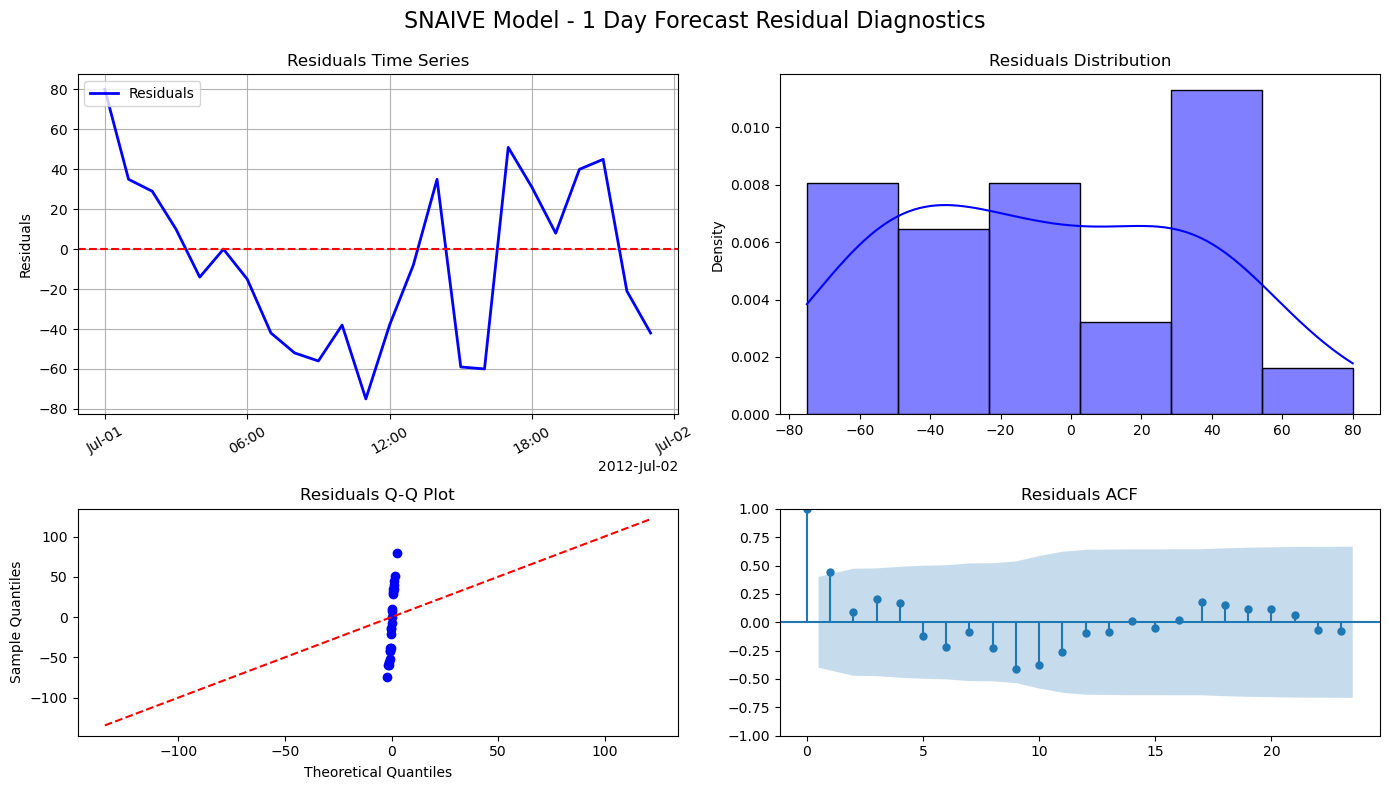

In [64]:
n_residuals = len(snaive_1day_residuals)
lags_to_use = min(24, n_residuals - 1)

fig, ax = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [0.6, 0.4]})
fig.suptitle("SNAIVE Model - 1 Day Forecast Residual Diagnostics", fontsize=16)

ax[0, 0].plot(snaive_1day_residuals.index, snaive_1day_residuals, color='blue', label='Residuals', lw=2)
ax[0, 0].axhline(0, color='red', linestyle='--')
ax[0, 0].set_title('Residuals Time Series')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].legend(loc="upper left")
ax[0, 0].grid(True)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax[0, 0].xaxis.set_major_locator(locator)
ax[0, 0].xaxis.set_major_formatter(formatter)
plt.setp(ax[0, 0].xaxis.get_majorticklabels(), rotation=30)

sns.histplot(snaive_1day_residuals, kde=True, stat='density', color='blue', ax=ax[0, 1])
ax[0, 1].set_title('Residuals Distribution')
ax[0, 1].set_ylabel('Density')

mu = snaive_1day_residuals.mean()
sigma = snaive_1day_residuals.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1, 0].scatter(stats.norm.ppf(np.linspace(0.01, 0.99, len(snaive_1day_residuals))), np.sort(snaive_1day_residuals), color='blue')
ax[1, 0].plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')
ax[1, 0].set_title('Residuals Q-Q Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

plot_acf(snaive_1day_residuals.dropna(), lags=lags_to_use, ax=ax[1, 1])
ax[1, 1].set_title('Residuals ACF')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

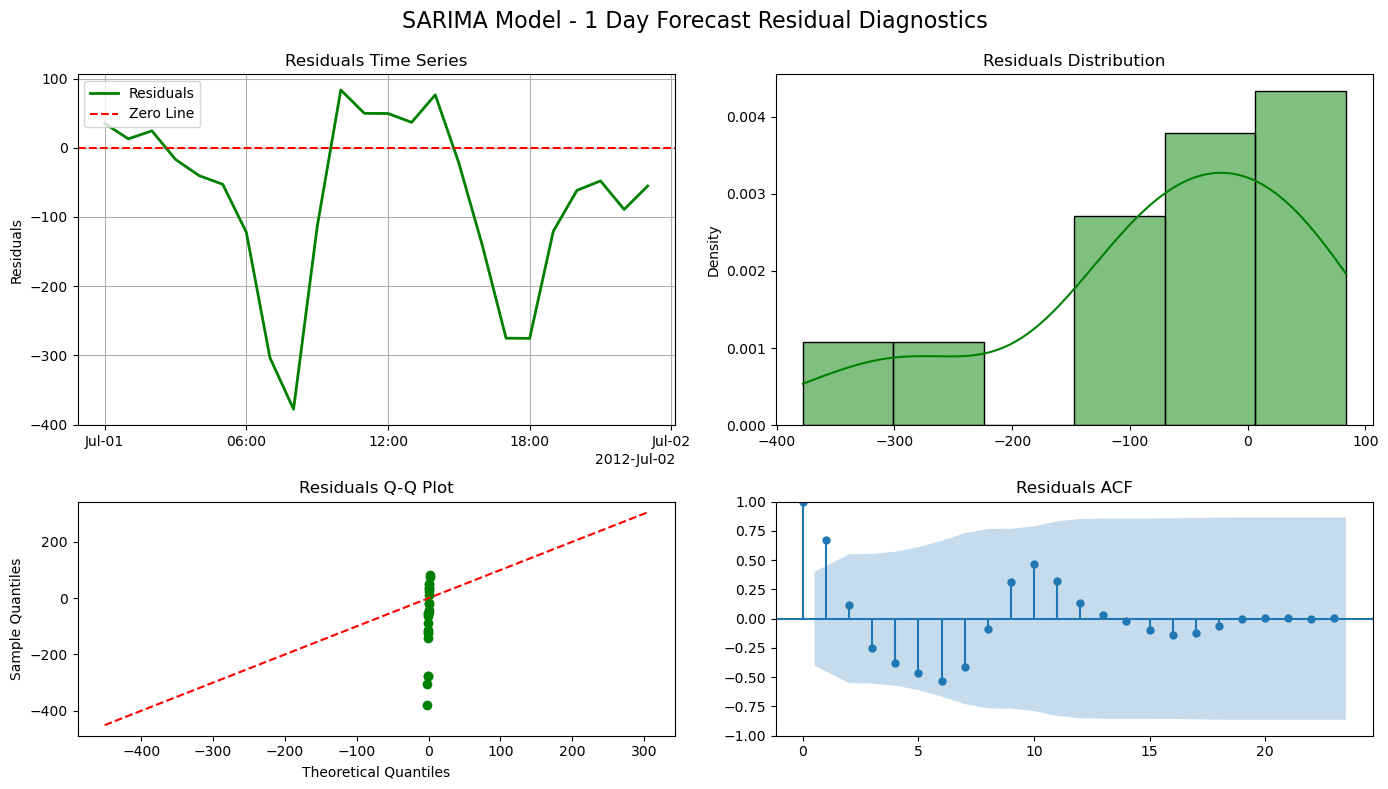

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [0.6, 0.4]})
fig.suptitle("SARIMA Model - 1 Day Forecast Residual Diagnostics", fontsize=16)

ax[0, 0].plot(sarima_1day_residuals.index, sarima_1day_residuals, color='green', label='Residuals', lw=2)
ax[0, 0].axhline(0, color='red', linestyle='--', label='Zero Line')
ax[0, 0].set_title('Residuals Time Series')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].legend(loc="upper left")
ax[0, 0].grid(True)

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax[0, 0].xaxis.set_major_locator(locator)
ax[0, 0].xaxis.set_major_formatter(formatter)

sns.histplot(sarima_1day_residuals, kde=True, stat='density', color='green', ax=ax[0, 1])
ax[0, 1].set_title('Residuals Distribution')
ax[0, 1].set_ylabel('Density')

mu = sarima_1day_residuals.mean()
sigma = sarima_1day_residuals.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1, 0].scatter(stats.norm.ppf(np.linspace(0.01, 0.99, len(sarima_1day_residuals))), np.sort(sarima_1day_residuals), color='green')
ax[1, 0].plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')
ax[1, 0].set_title('Residuals Q-Q Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

max_lags = min(24, len(sarima_1day_residuals.dropna()) - 1)
plot_acf(sarima_1day_residuals.dropna(), lags=max_lags, ax=ax[1, 1])
ax[1, 1].set_title('Residuals ACF')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Let's overview what have we got for 1 day forecast residuals for both models. So SARIM model shows significanlt larger residual magnitudes compared to the SNAIVE model, which means that SARIMA produces larger forecast errors for 1 day horizon. SNAIVE's residuals appear more normally distributed with relatively bell shaped historgram compared to SARIMA and SNAIVE also shows better adherence to nomrality based on a QQ plot. Based on the ACF plots, both models show significant autocorrelation in their residuals, but still, SNAIVE has less stronger spikes so it outperforms SARIMA in this case too

Let's now compare this models residuals no a different forecast horizon

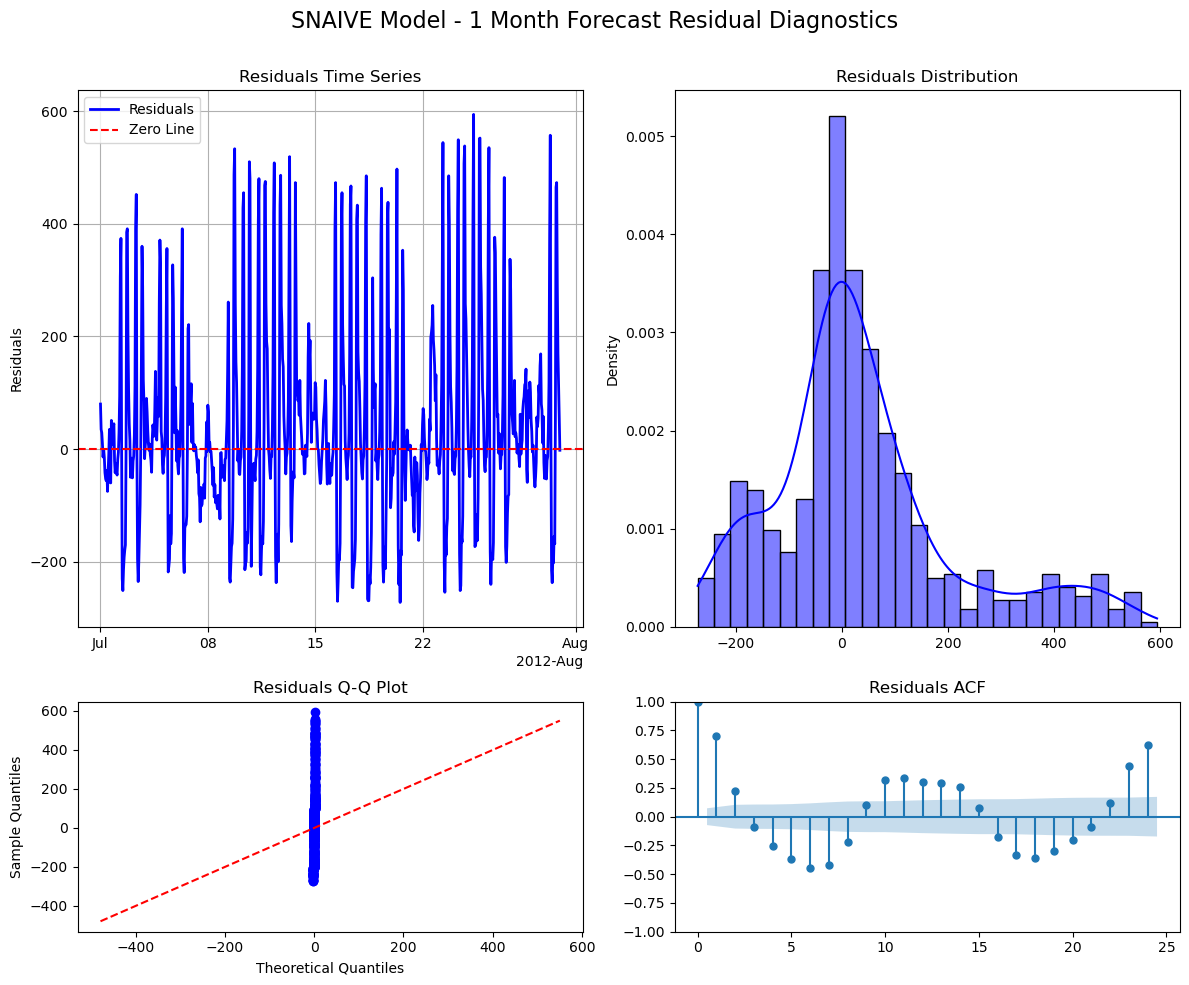

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [0.7, 0.3]})
fig.suptitle("SNAIVE Model - 1 Month Forecast Residual Diagnostics", fontsize=16)

ax[0, 0].plot(snaive_1month_residuals.index, snaive_1month_residuals, color='blue', label='Residuals', lw=2)
ax[0, 0].axhline(0, color='red', linestyle='--', label='Zero Line')
ax[0, 0].set_title('Residuals Time Series')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].legend(loc="upper left")
ax[0, 0].grid(True)

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax[0, 0].xaxis.set_major_locator(locator)
ax[0, 0].xaxis.set_major_formatter(formatter)

sns.histplot(snaive_1month_residuals, kde=True, stat='density', color='blue', ax=ax[0, 1])
ax[0, 1].set_title('Residuals Distribution')
ax[0, 1].set_ylabel('Density')

mu = snaive_1month_residuals.mean()
sigma = snaive_1month_residuals.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1, 0].scatter(stats.norm.ppf(np.linspace(0.01, 0.99, len(snaive_1month_residuals))), np.sort(snaive_1month_residuals), color='blue')
ax[1, 0].plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')
ax[1, 0].set_title('Residuals Q-Q Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

max_lags = min(24, len(snaive_1month_residuals.dropna()) - 1)
plot_acf(snaive_1month_residuals.dropna(), lags=max_lags, ax=ax[1, 1])
ax[1, 1].set_title('Residuals ACF')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

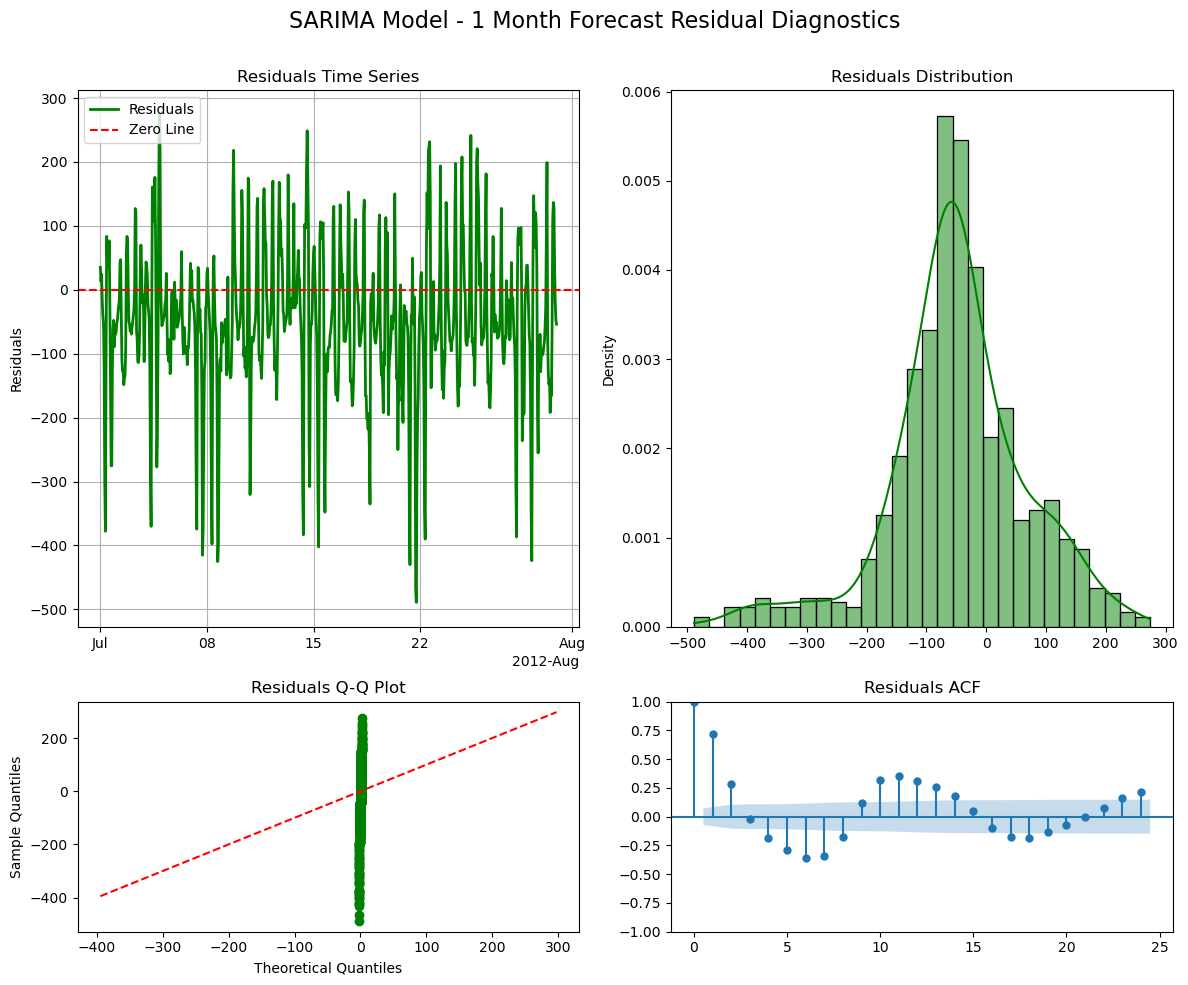

In [69]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [0.7, 0.3]})
fig.suptitle("SARIMA Model - 1 Month Forecast Residual Diagnostics", fontsize=16)

ax[0, 0].plot(sarima_1month_residuals.index, sarima_1month_residuals, color='green', label='Residuals', lw=2)
ax[0, 0].axhline(0, color='red', linestyle='--', label='Zero Line')
ax[0, 0].set_title('Residuals Time Series')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].legend(loc="upper left")
ax[0, 0].grid(True)

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax[0, 0].xaxis.set_major_locator(locator)
ax[0, 0].xaxis.set_major_formatter(formatter)

sns.histplot(sarima_1month_residuals, kde=True, stat='density', color='green', ax=ax[0, 1])
ax[0, 1].set_title('Residuals Distribution')
ax[0, 1].set_ylabel('Density')

mu = sarima_1month_residuals.mean()
sigma = sarima_1month_residuals.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1, 0].scatter(stats.norm.ppf(np.linspace(0.01, 0.99, len(sarima_1month_residuals))), np.sort(sarima_1month_residuals), color='green')
ax[1, 0].plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')
ax[1, 0].set_title('Residuals Q-Q Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

max_lags = min(24, len(sarima_1month_residuals.dropna()) - 1)
plot_acf(sarima_1month_residuals.dropna(), lags=max_lags, ax=ax[1, 1])
ax[1, 1].set_title('Residuals ACF')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

So firstly, based on the time series residual plot, SNAIVE shows significantly larger residuals magnitudes compared to the SARIMA. SARIMA also has more symmetric and bell shaped histogram, suggesting desirable statistical properties for residuals. About ACF plot, both models again show autocorrelation in their residuals, but SARIMA model shows more damped autocorrelation pattern with seasonal components at regular intervals unlike the SNAIVE. To conclucde, for 1 day forecasts SNAIVE outperformed SARIMA in every aspect of residual diagnostics, but we have a different picture as expected on 1 month horizon, in a long term case, SARIMA is the winner in every aspect, which is pretty logical, because simpler models like SNAIVE may work well for very short term forecasts, more sophisticated models like SARIMA become increasingly valuable as the forecast horizon extends, because it can capture more complex patterns in the data